In [2]:
import pickle as pk
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import torch
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#load pickle data

file_path = '/content/drive/MyDrive/Colab Notebooks/bfn_exercise.pkl'
with open(file_path, 'rb') as file:
  loaded_data = pk.load(file)

# print("loaded_data", loaded_data)

In [ ]:
type(loaded_data)

list

In [ ]:
df = pd.DataFrame(loaded_data)
# print(df)

In [ ]:
first_index = loaded_data[0]
len(first_index)

3

In [ ]:
print(len(first_index))
type(first_index)

3


dict

In [ ]:
type(loaded_data)

list

# Description of what the loaded data is:

The loaded_data file is a list and has been converted to a pandas dataframe for visulaization.
I observed that the loaded_data has 1000000 rows. Each of the element in the list, or each index/row in the loaded data list is a dictionary, consisting three keys: emb_smiles, logp and qed. The emb_smile key has the value which is a list and size 256 (consisting of values) and the other two keys has one singluar floating point value. It matched with the description provided in the prompt.


In [ ]:
#cutting the dataset into first 500
trunicated_loaded_data = loaded_data[:500]
df_500 = pd.DataFrame(loaded_data)

# Linear regressor to learn the function
Trained on all the dataset and not just 500 (as the variable name implies)


In [ ]:
# Flatten the 'emb_smiles' field
df_500['emb_smiles'] = df_500['emb_smiles'].apply(lambda x: x.flatten())

# Split the dataset into features (X) and target (y)
X = np.vstack(df_500['emb_smiles'].values)  # Flattened latent codes
y = df_500['logp'].values  # Target (logp)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a linear regression model
regressor = LinearRegression()

# Fit the model on the training data
regressor.fit(X_train, y_train)

# Predict on the test set
y_pred = regressor.predict(X_test)

# Calculate the mean squared error and R-squared
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 0.34901226799826635
R-squared: 0.8579139585362705


In [ ]:
# Access 'emb_smiles' from all dictionaries in the list
emb_smiles_data_list = [d['emb_smiles'] for d in loaded_data[:500]]

In [ ]:
# Create and fit a Min-Max scaler to map data to (-1, 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
#reshaped to match the input of the BNF model (as it is based on images)
emb_smiles_data = (scaler.fit_transform(emb_smiles_data_list)).reshape(500, 1, 16,16)
print(emb_smiles_data.shape)

(500, 1, 16, 16)


# Setting the BFN modules

In [ ]:
#clone
!git clone https://github.com/yoimers/bayesian-flow-networks-animeface

Cloning into 'bayesian-flow-networks-animeface'...
remote: Enumerating objects: 106, done.
remote: Counting objects: 100% (106/106), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 106 (delta 39), reused 89 (delta 24), pack-reused 0
Receiving objects: 100% (106/106), 13.27 MiB | 34.31 MiB/s, done.
Resolving deltas: 100% (39/39), done.


In [ ]:
# Import and use functions from the repository
from bayesian_flow_networks_animeface.bfns import bfn_continuous


In [ ]:
from bayesian_flow_networks_animeface.networks import unet

unet_model = unet
input=  1
output = 1
model = unet.UNet(input, output)

In [ ]:
# Adjust input dimensions, neural network architecture, and other parameters as needed
bfn_model = bfn_continuous.BFNContinuousData(unet=model, in_channels=input, sigma=0.001)


In [ ]:
print(type(emb_smiles_data))

<class 'numpy.ndarray'>


# Trainning the BFN generator module

In [ ]:
# Define your training parameters, optimizer, and loss function
optimizer = torch.optim.Adam(bfn_model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()  # You may need to choose an appropriate loss function

# Convert NumPy data to PyTorch tensors
emb_smiles_data = torch.FloatTensor(emb_smiles_data)

# Training loop
num_epochs = 1
for epoch in range(num_epochs):
    optimizer.zero_grad()
    predictions = bfn_model(emb_smiles_data, t=torch.zeros(len(emb_smiles_data)))  # Assuming t=0
    loss = loss_fn(predictions, emb_smiles_data)
    loss.backward()
    optimizer.step()
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')

checkpoint = {
    'epoch': num_epochs,
    'model_state_dict': bfn_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss.item()  # You can also save the current loss if needed
}

# Specify the file path where you want to save the checkpoint
checkpoint_path = 'checkpoint.pth'

# Save the checkpoint to the specified file
torch.save(checkpoint, checkpoint_path)

print(f'Model and optimizer states saved to {checkpoint_path}')
# Generate synthetic samples


In [ ]:
#loading the saved model and syhthesizing the data
checkpoint = torch.load('/content/drive/MyDrive/Colab Notebooks/checkpoint.pth')

# Extract the model_state_dict from the checkpoint
model_state_dict = checkpoint['model_state_dict']

bfn_model.load_state_dict(model_state_dict)
# Generate synthetic samples
num_samples = 500
#step size was reduced for convenience
synthetic_samples = bfn_model.sample(h=16, w=16, batch_size=num_samples,steps=10)



In [ ]:
synthetic_samples.shape

torch.Size([500, 1, 16, 16])

# Comparing Syntesized Data with the Original Emb_smiles data for each of the 256 dimension

(500, 256)


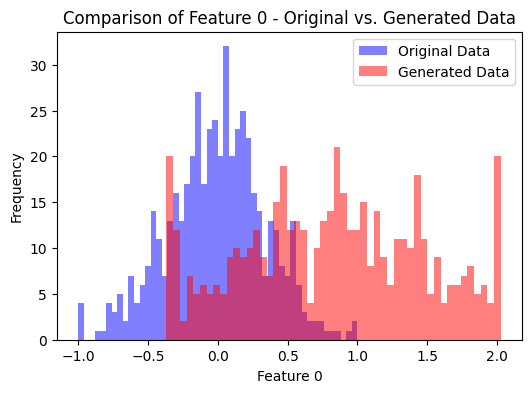

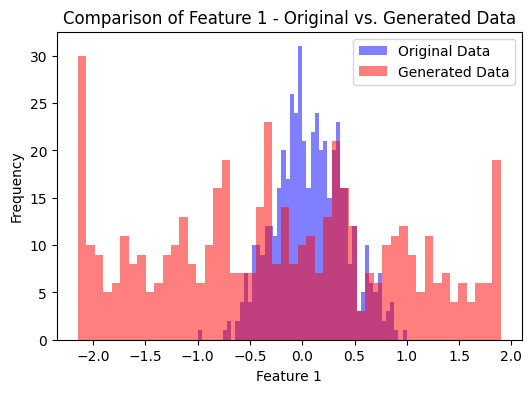

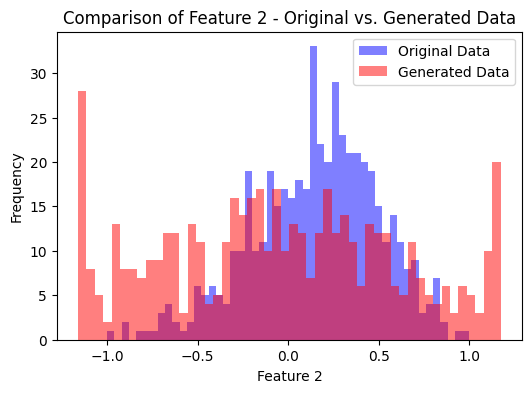

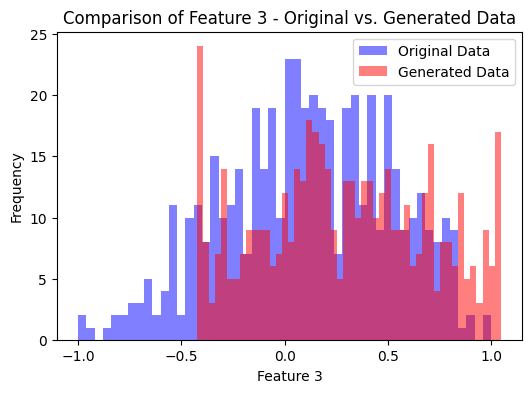

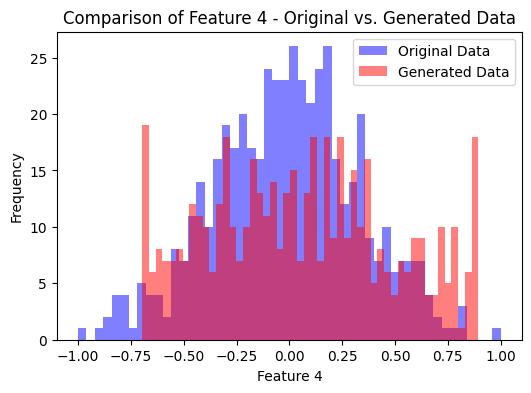

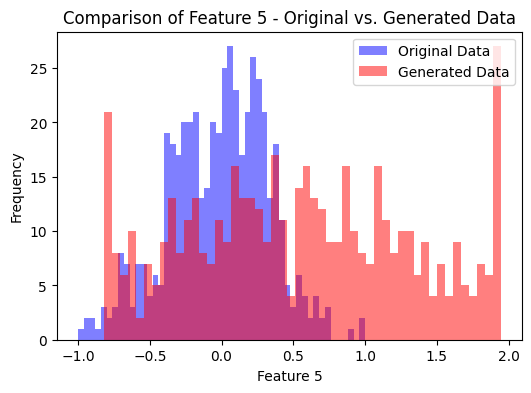

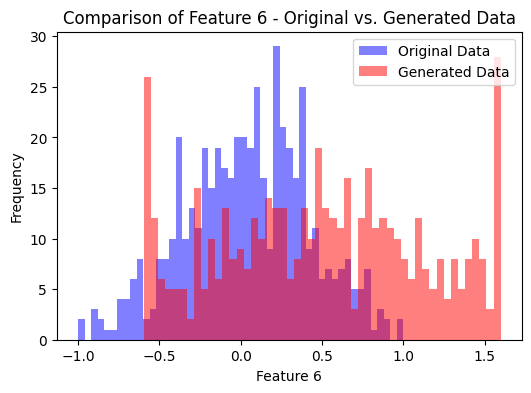

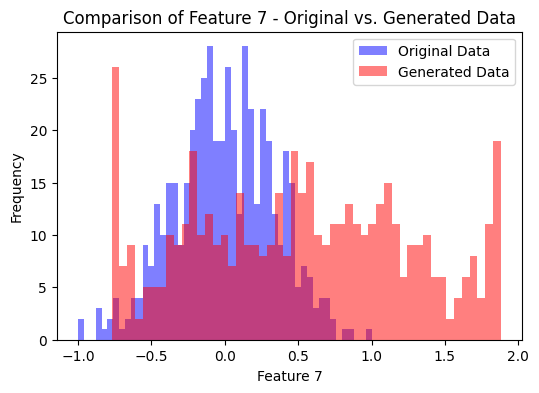

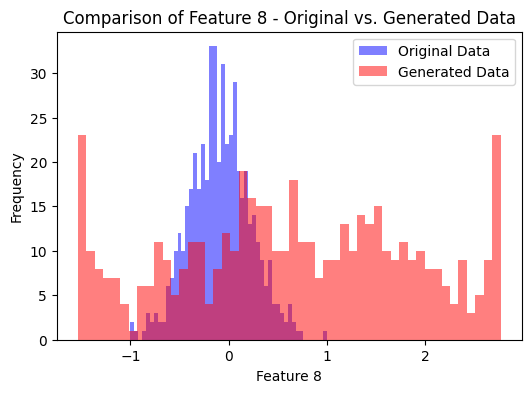

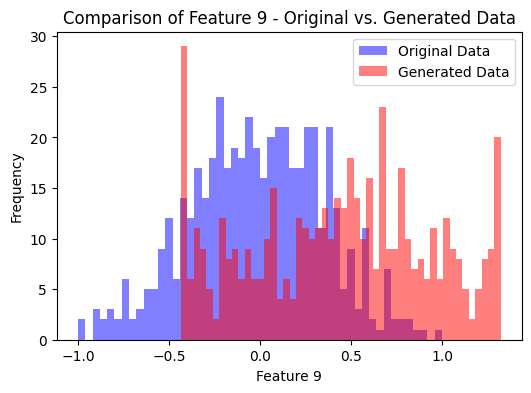

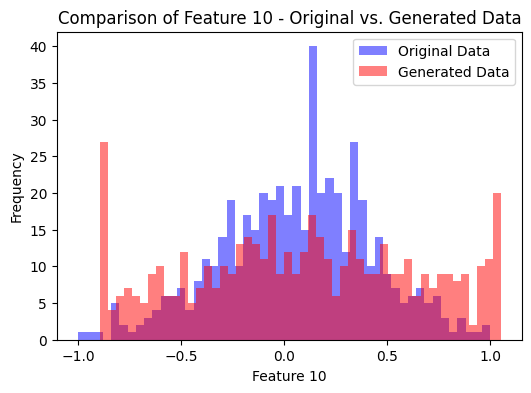

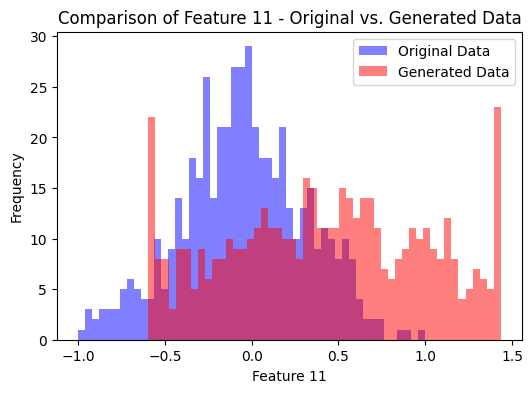

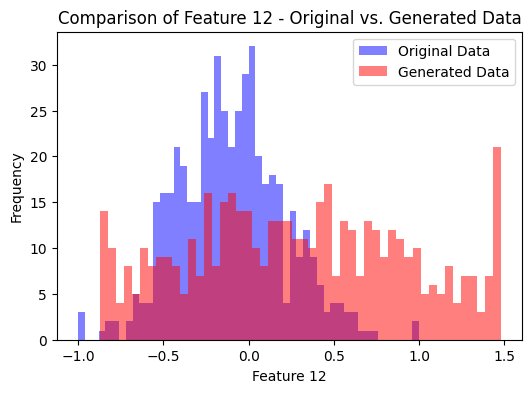

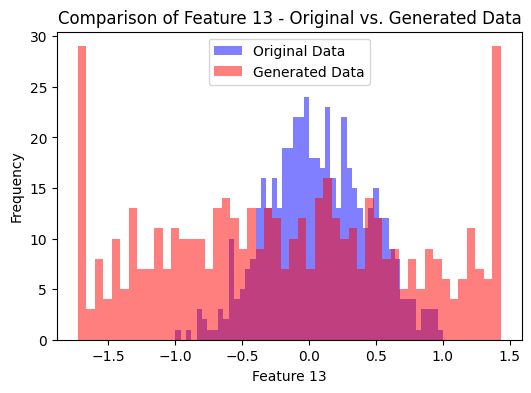

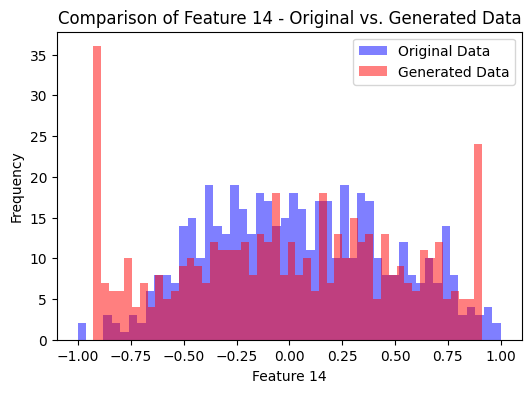

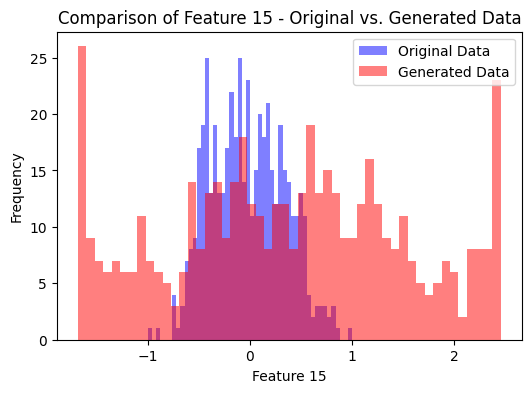

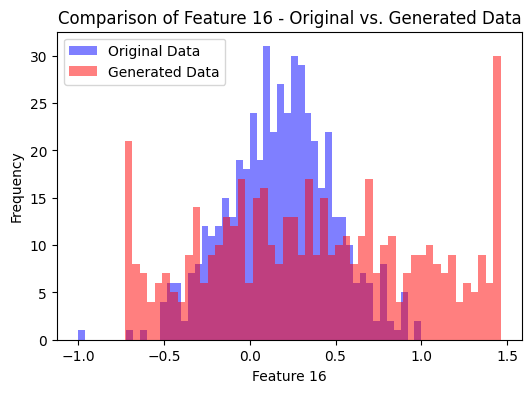

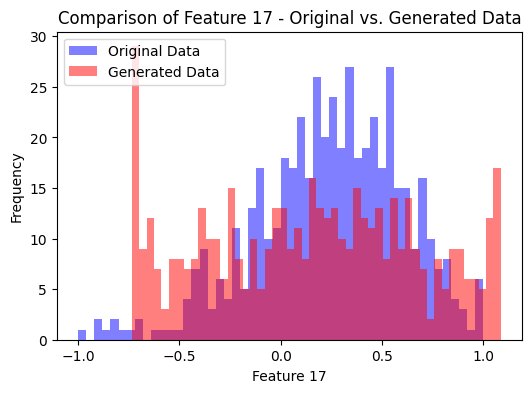

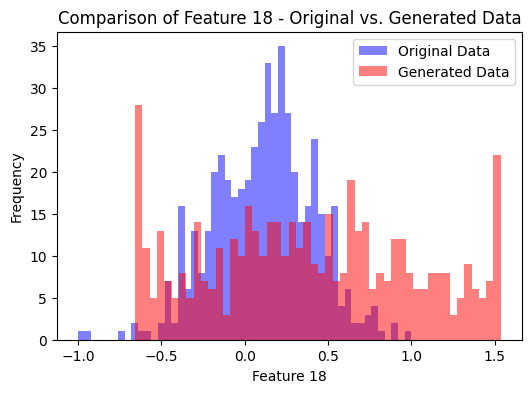

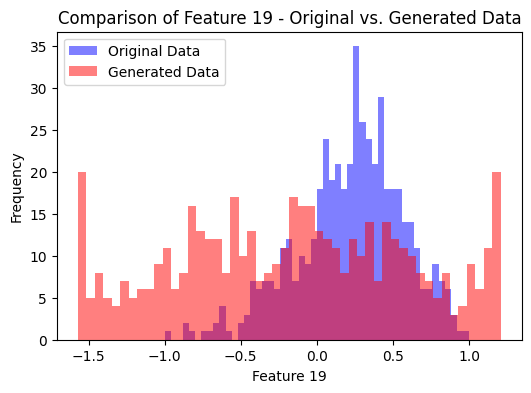

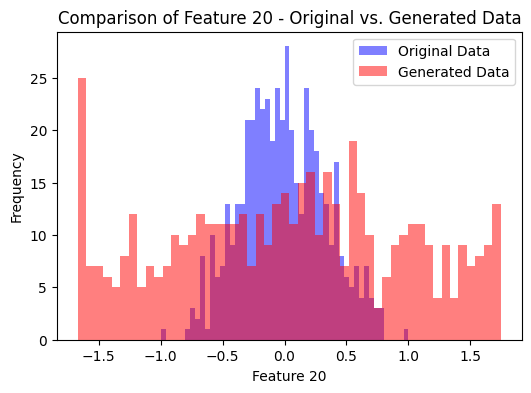

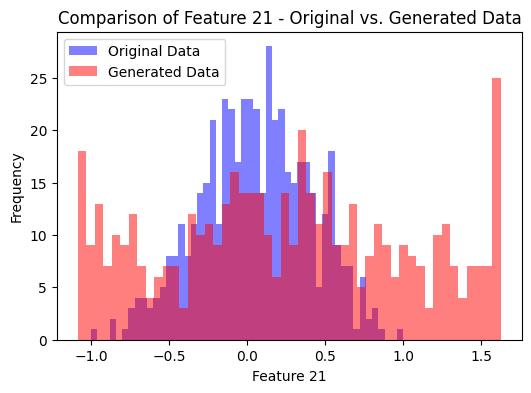

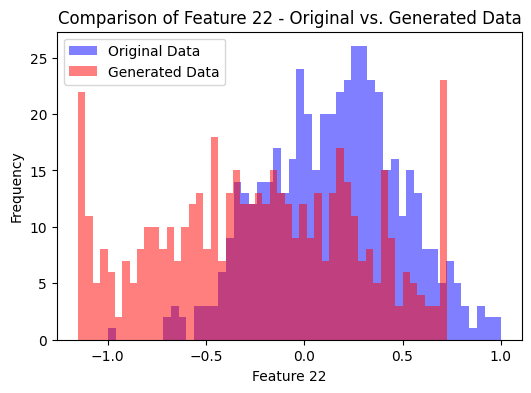

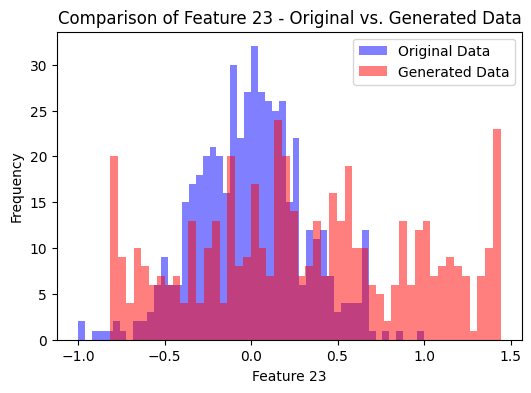

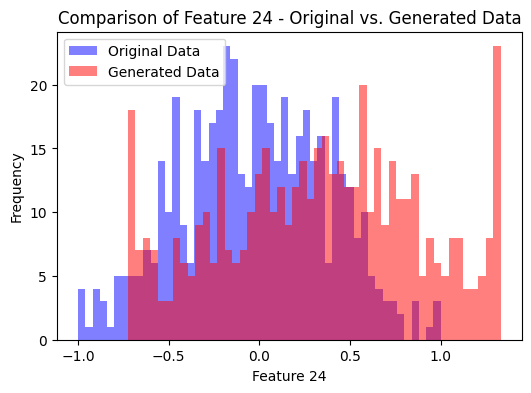

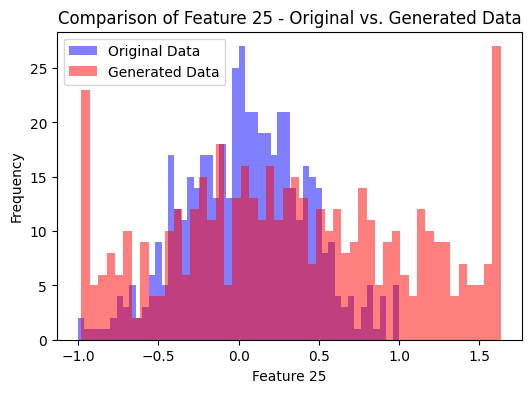

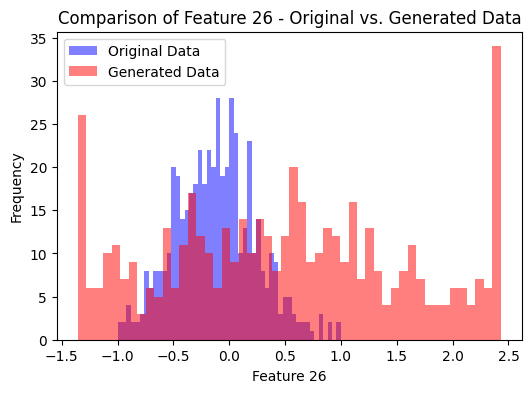

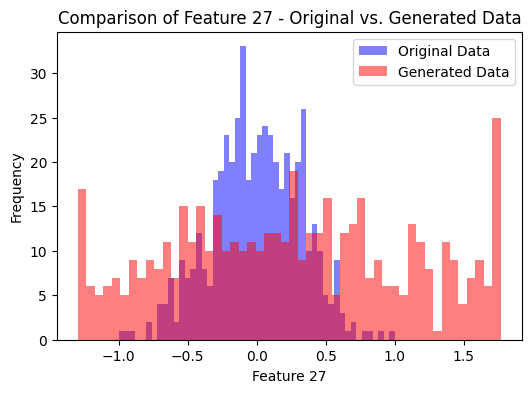

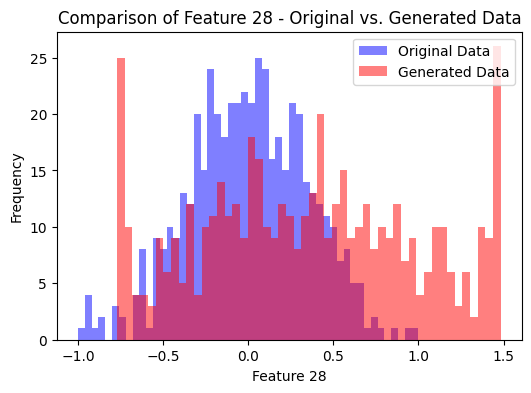

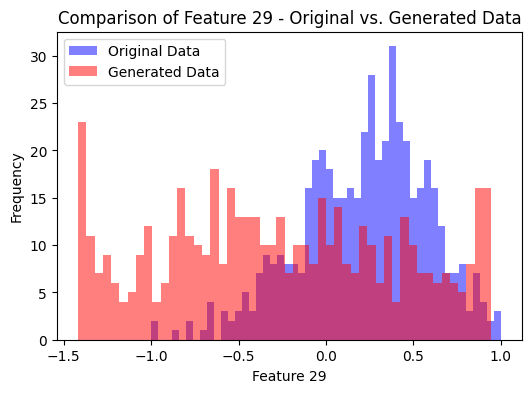

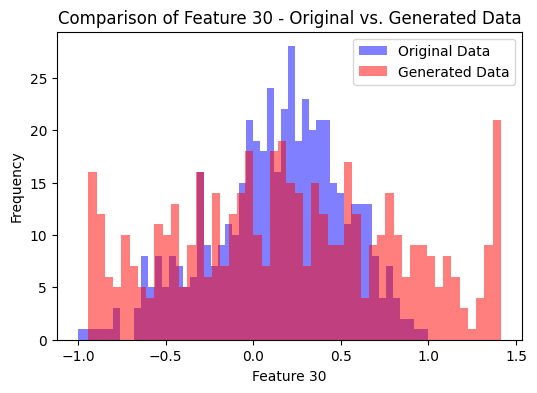

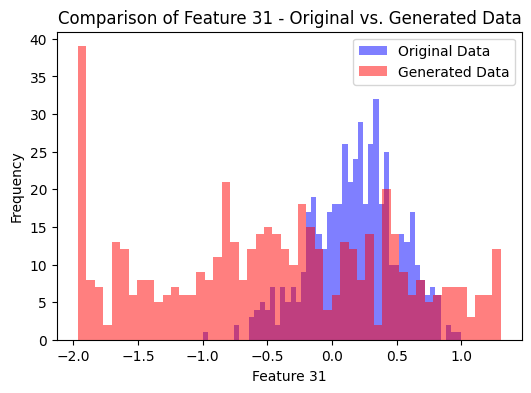

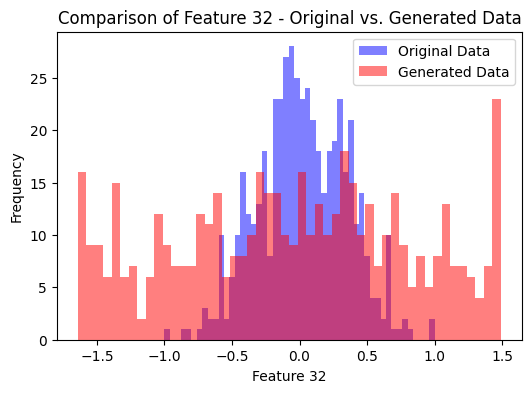

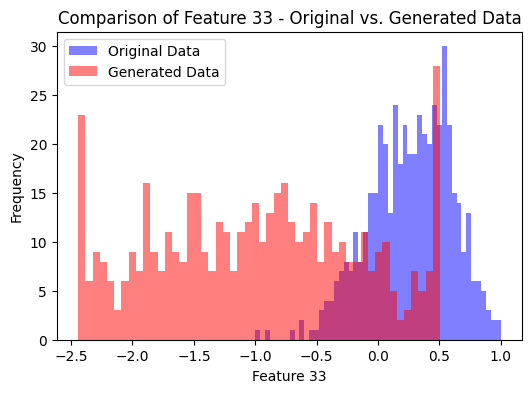

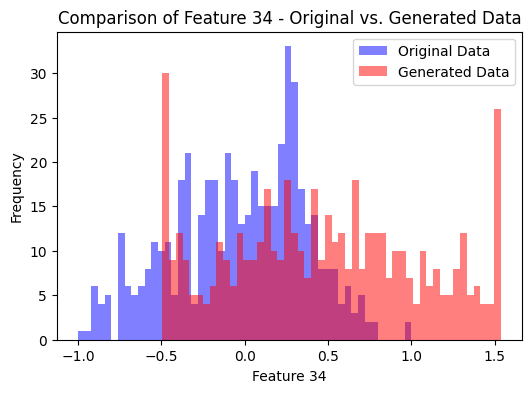

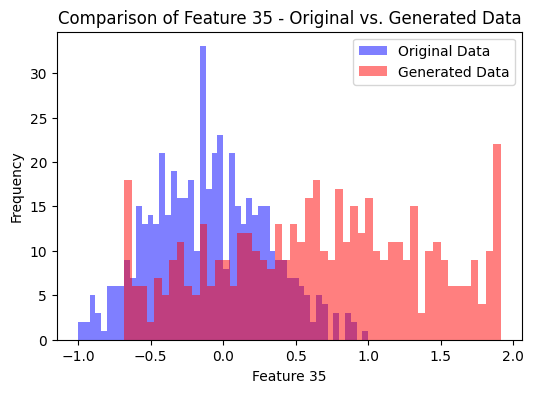

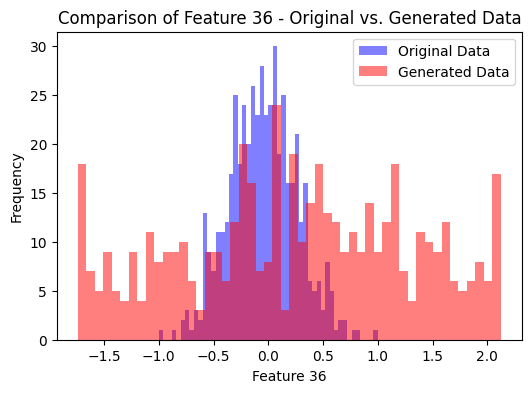

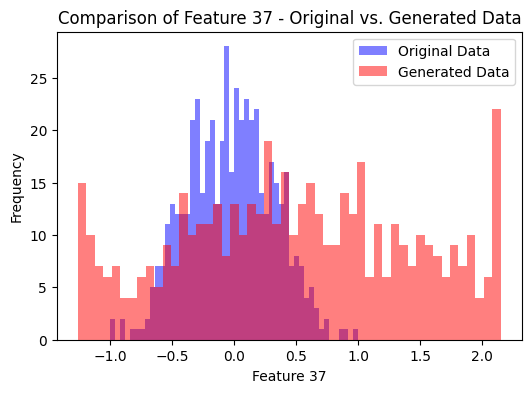

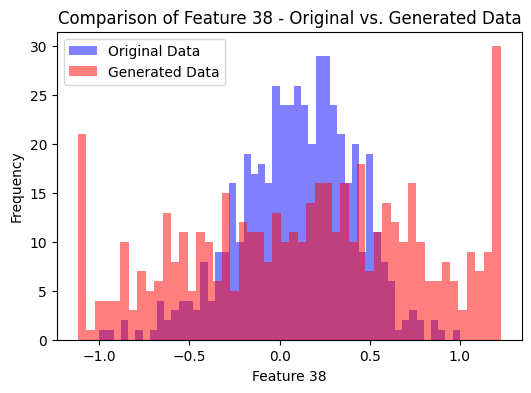

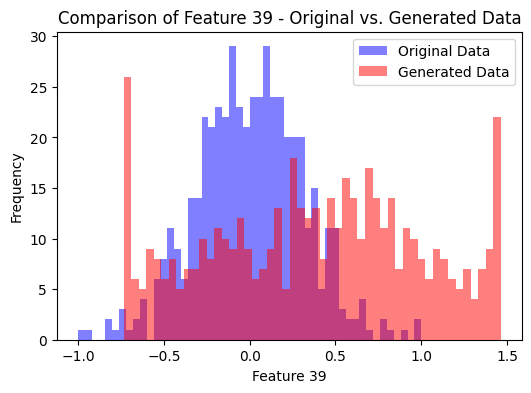

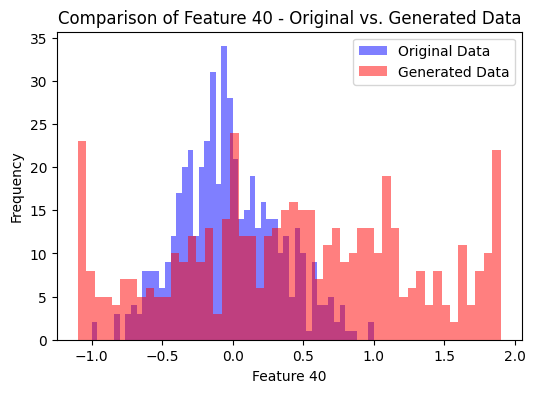

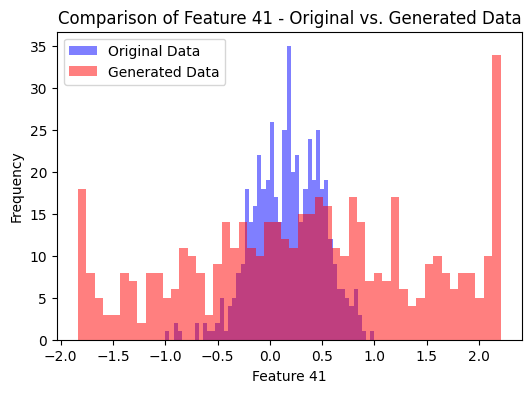

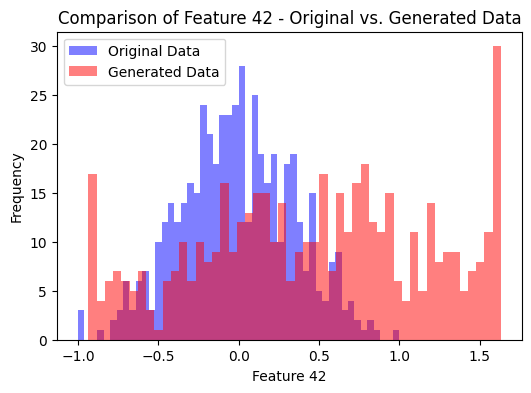

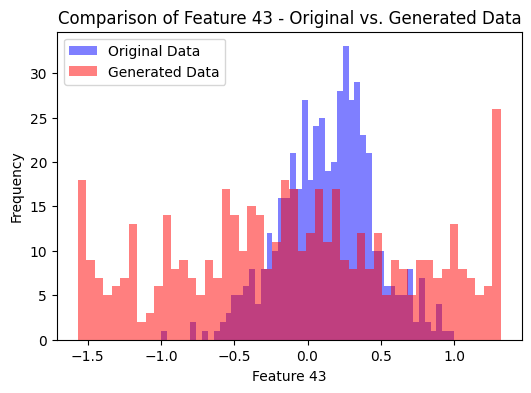

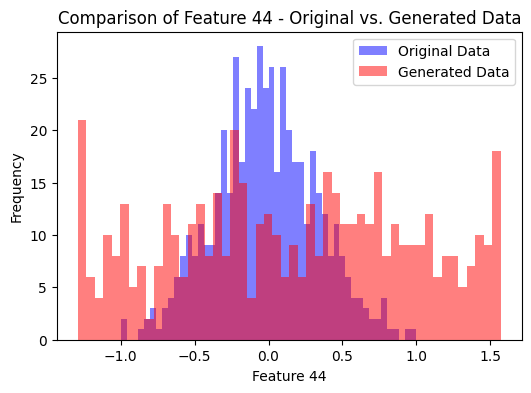

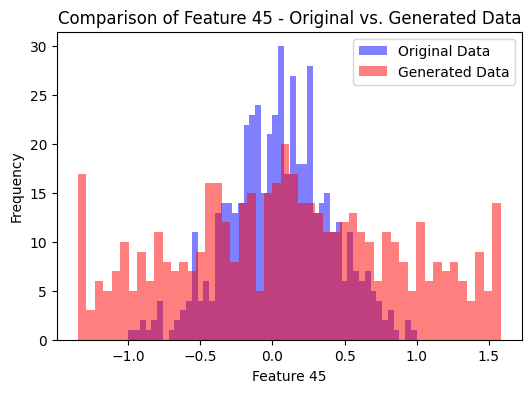

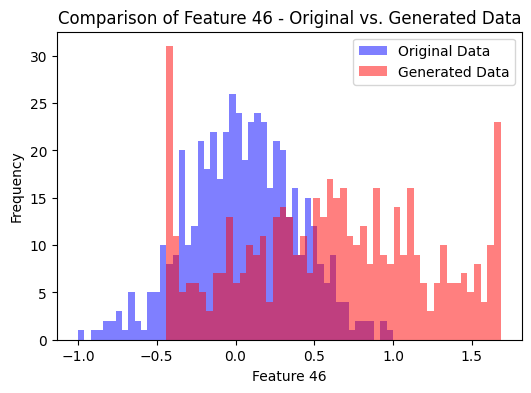

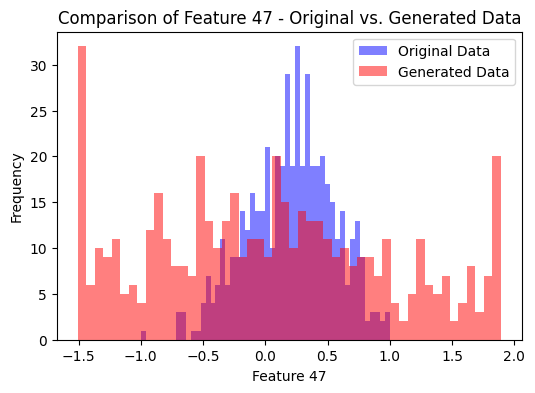

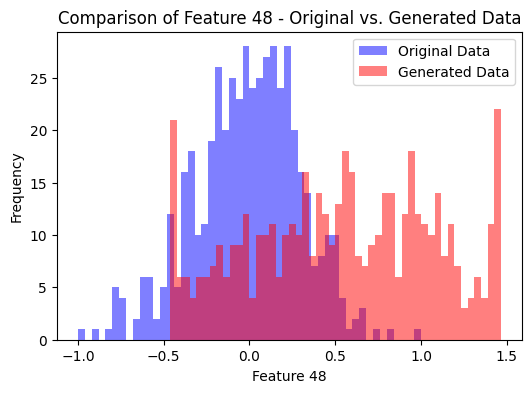

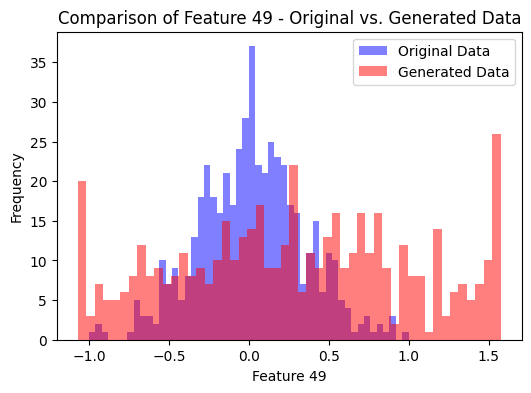

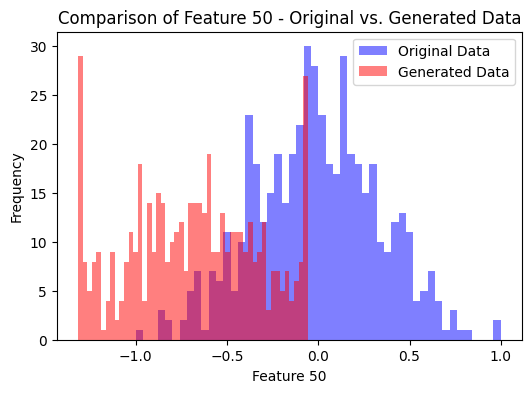

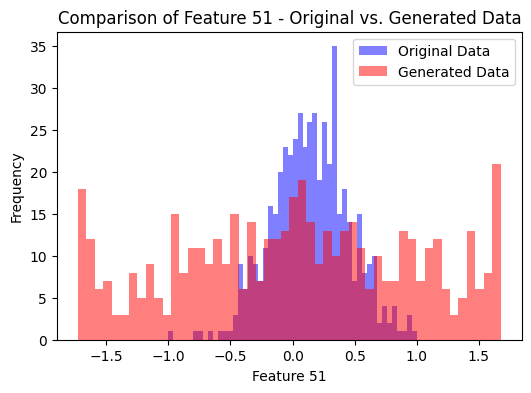

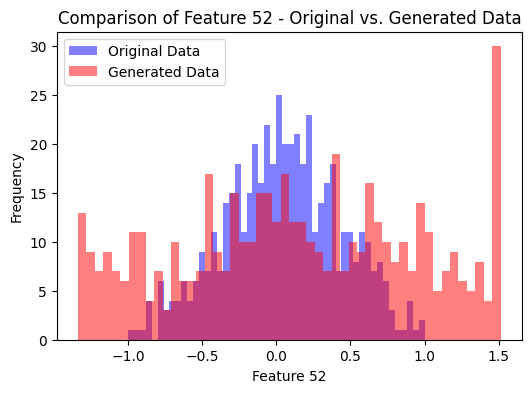

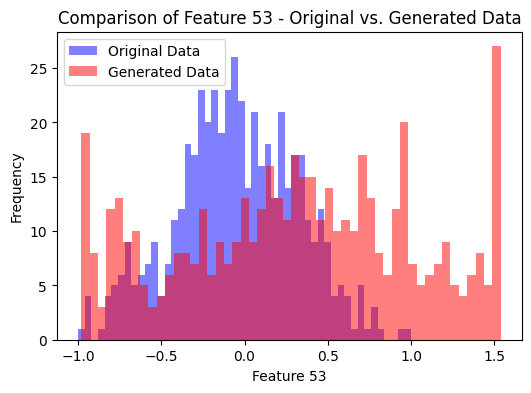

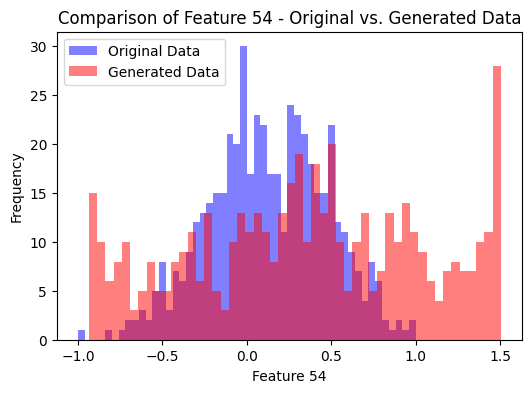

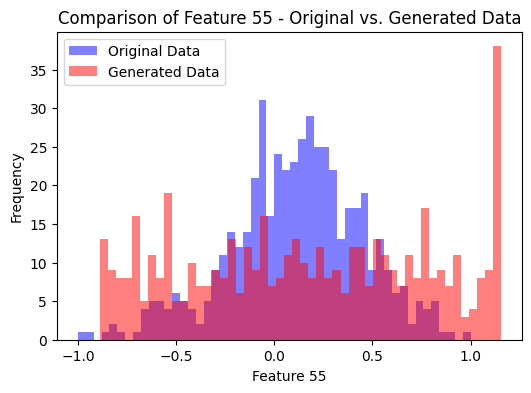

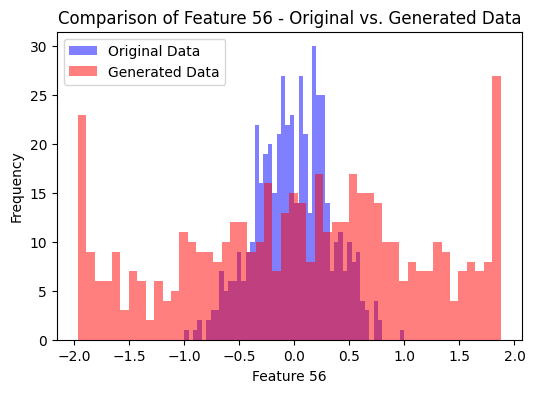

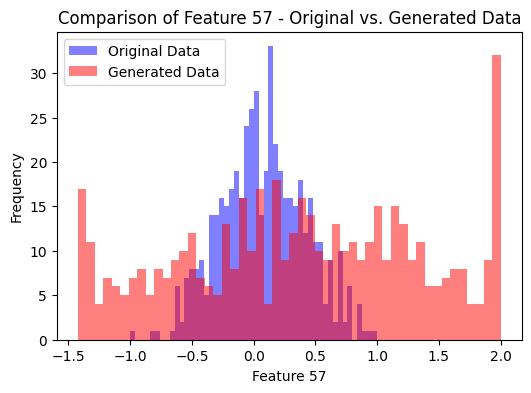

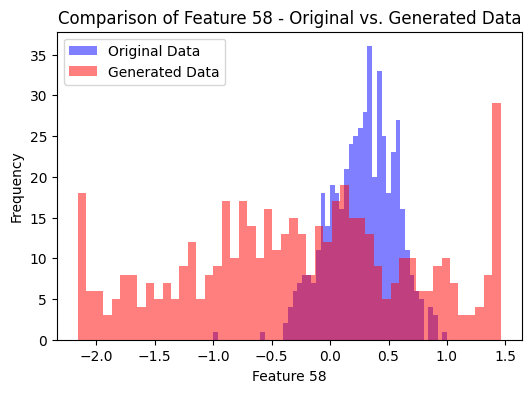

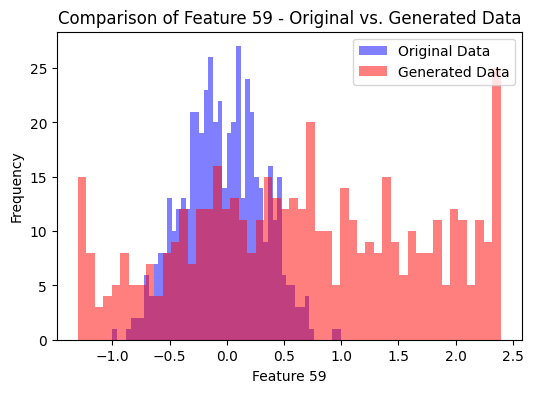

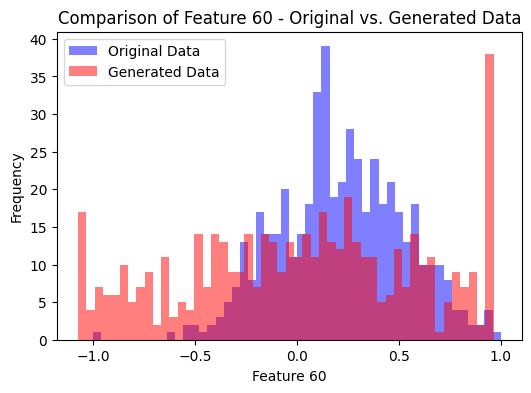

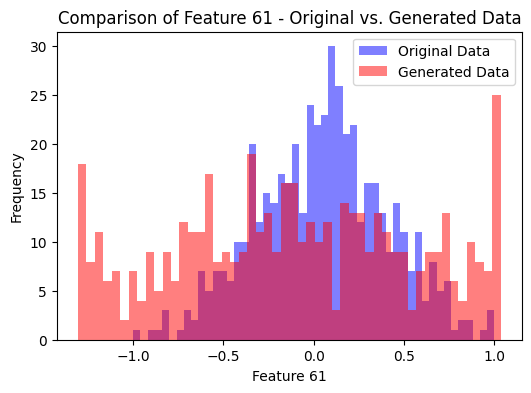

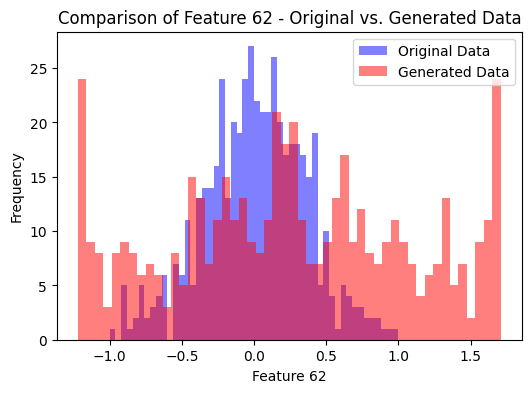

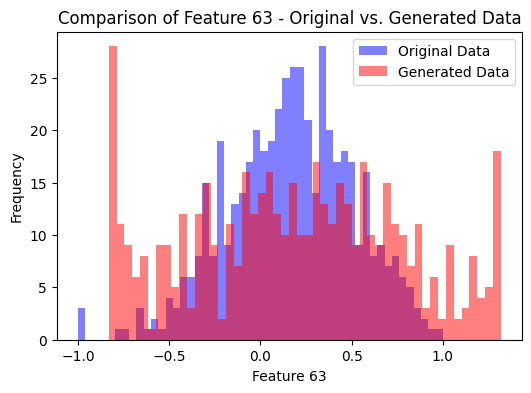

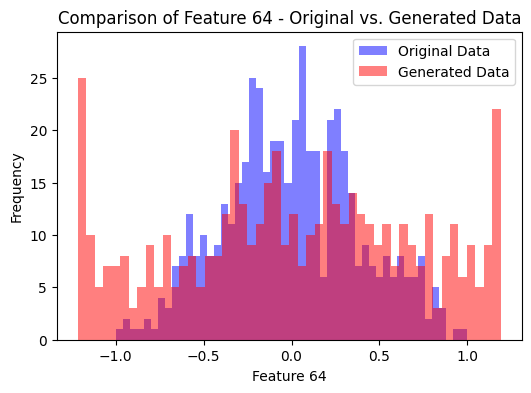

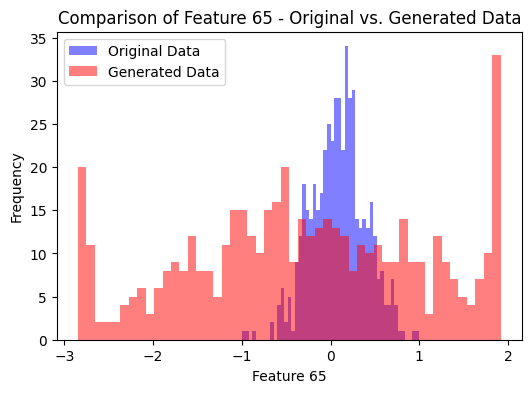

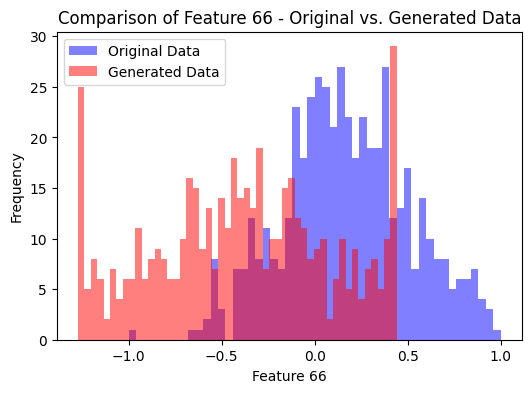

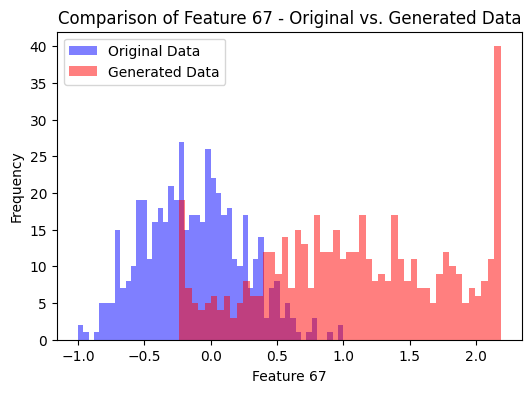

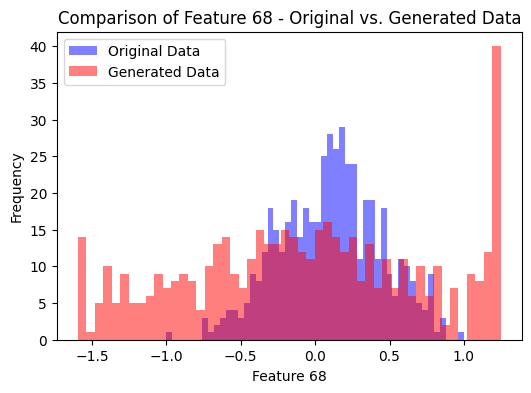

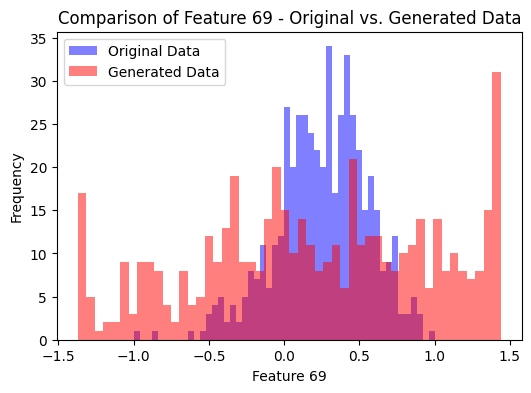

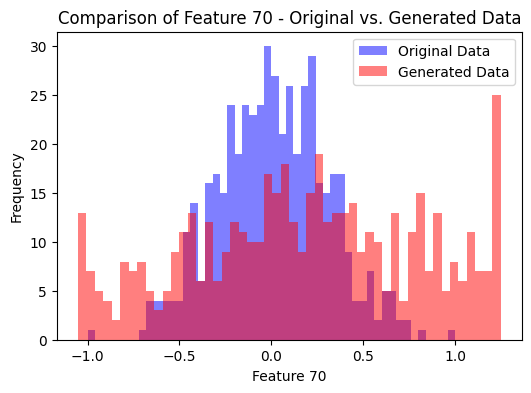

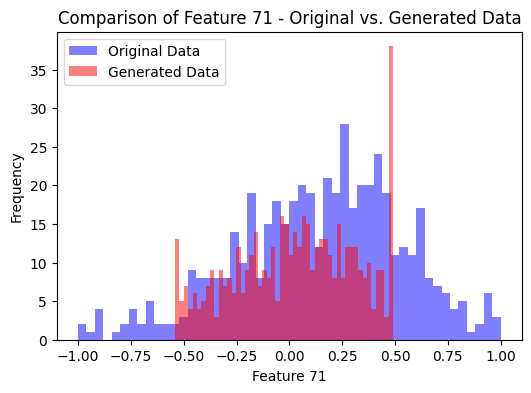

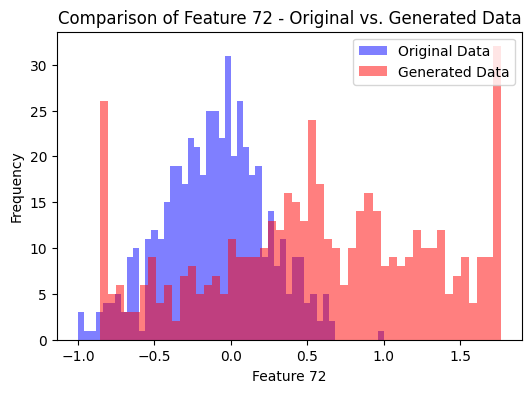

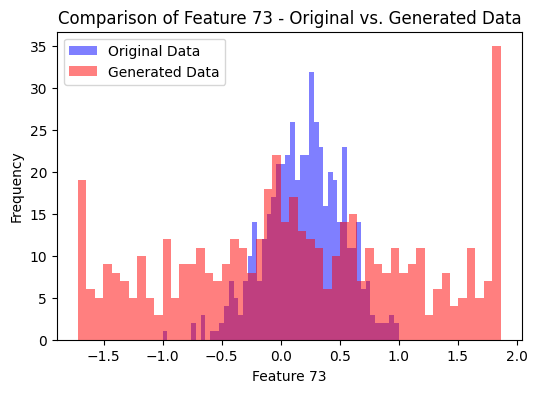

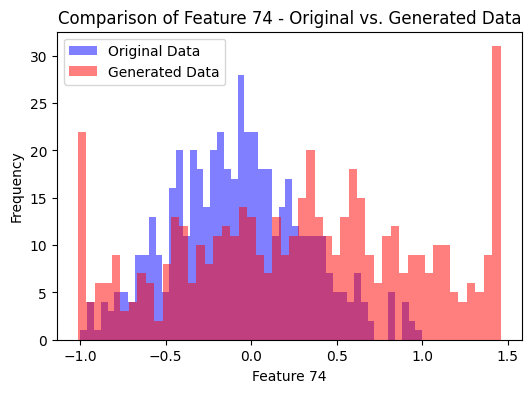

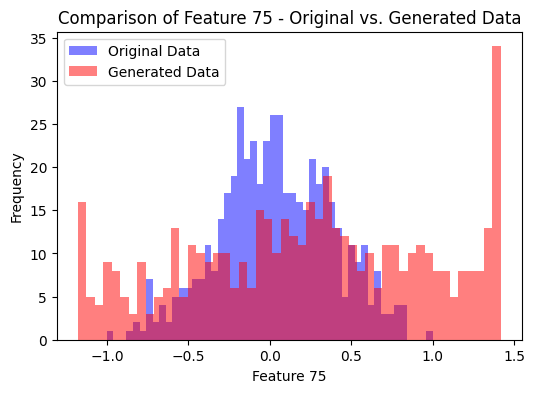

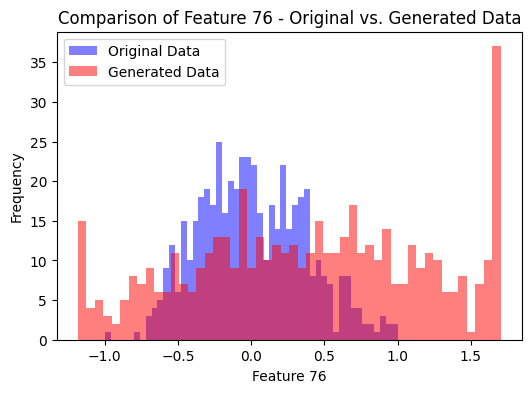

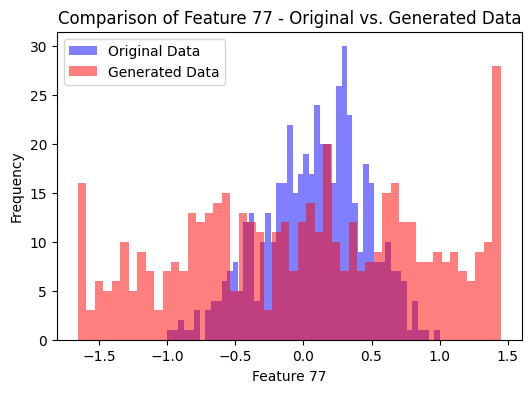

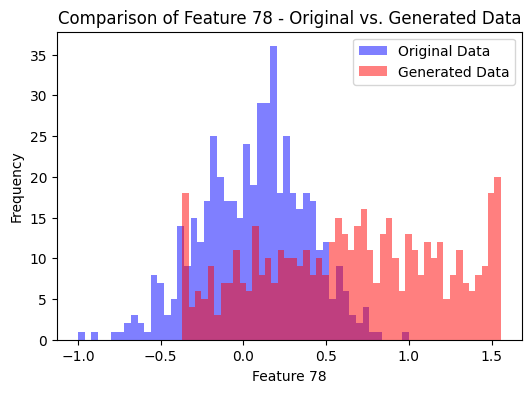

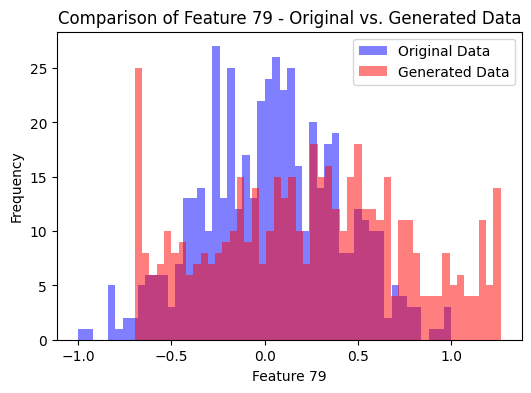

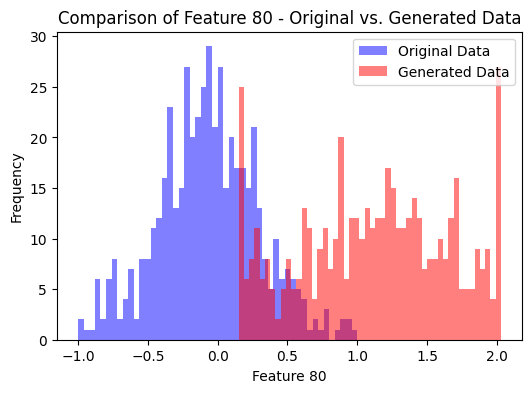

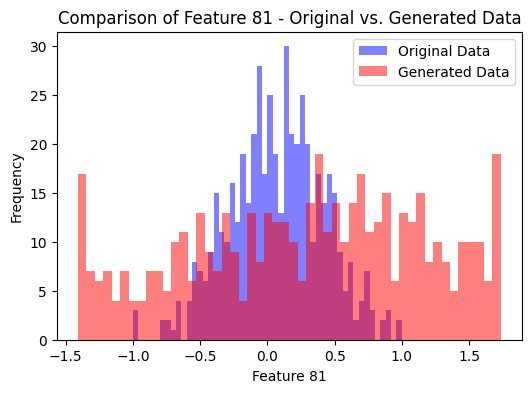

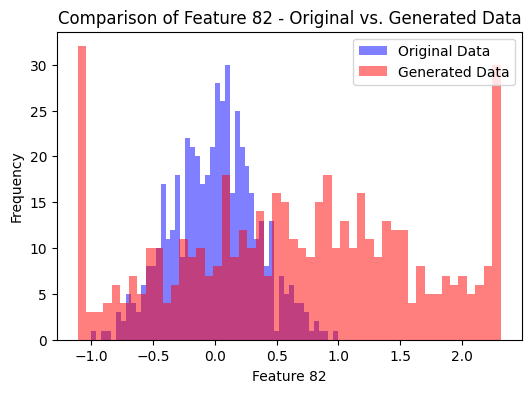

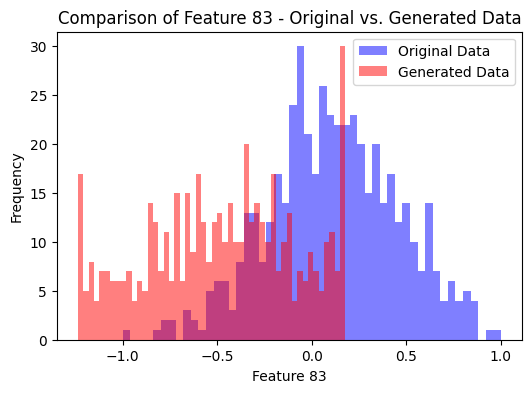

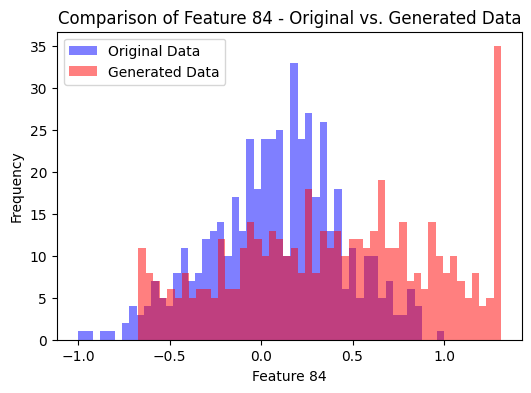

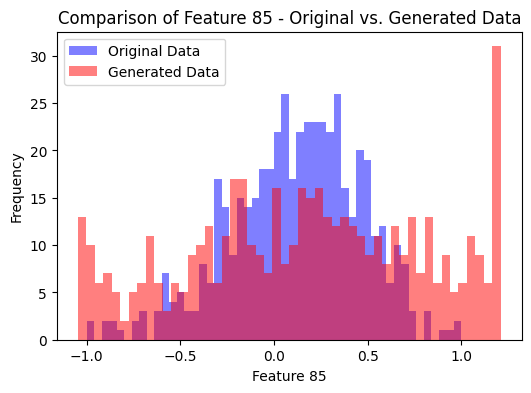

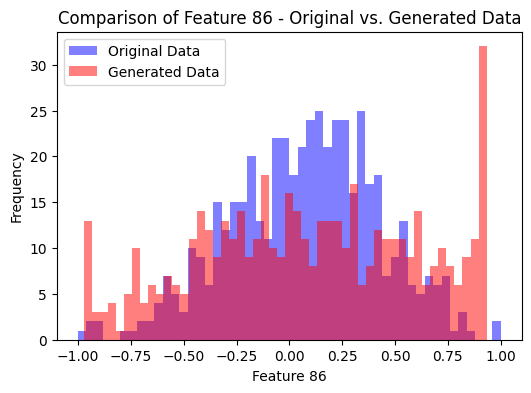

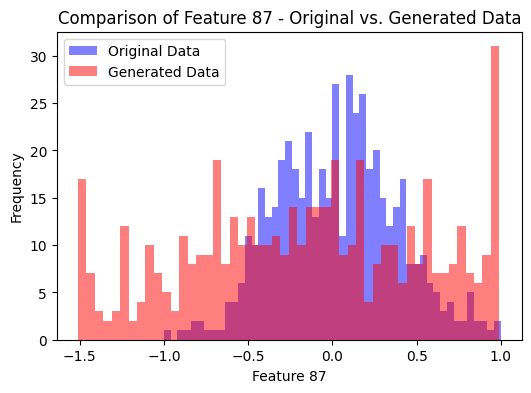

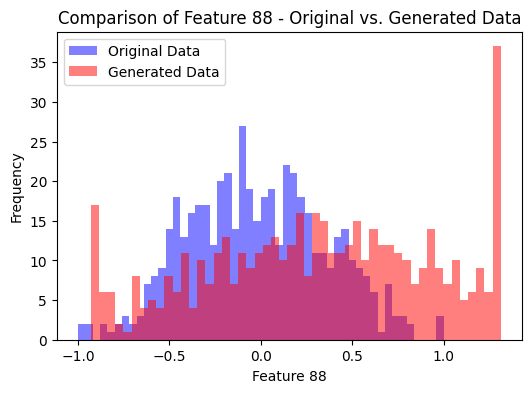

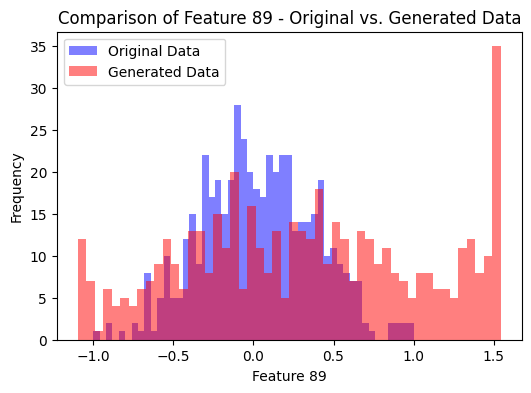

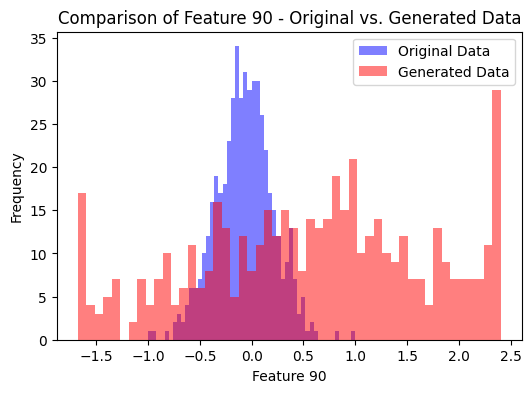

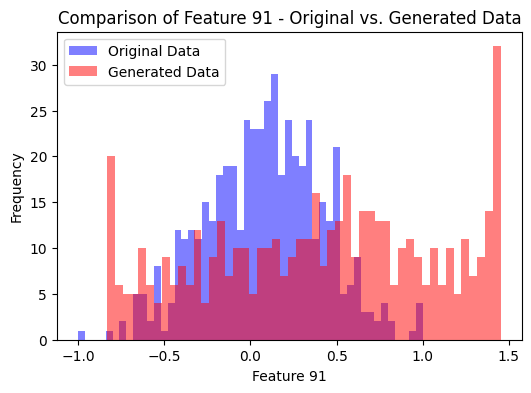

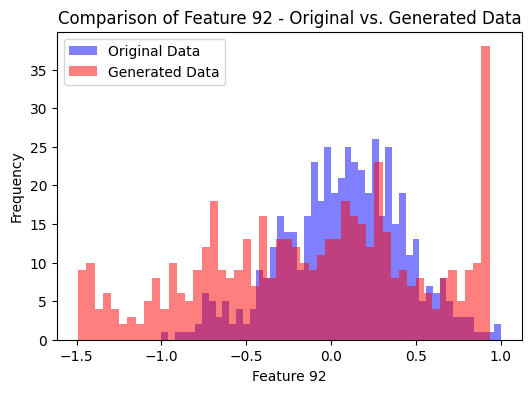

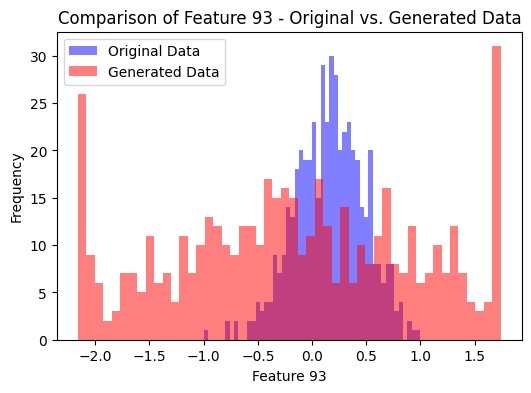

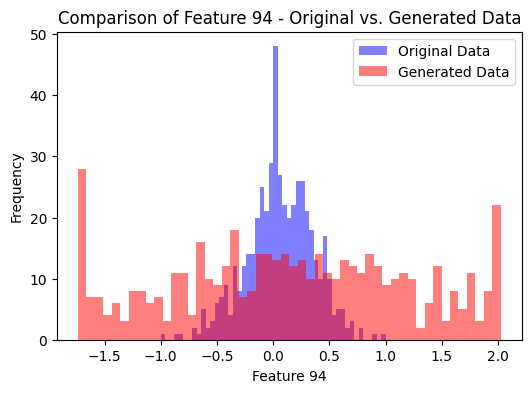

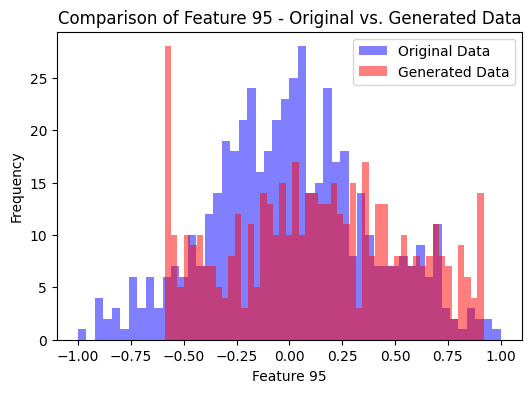

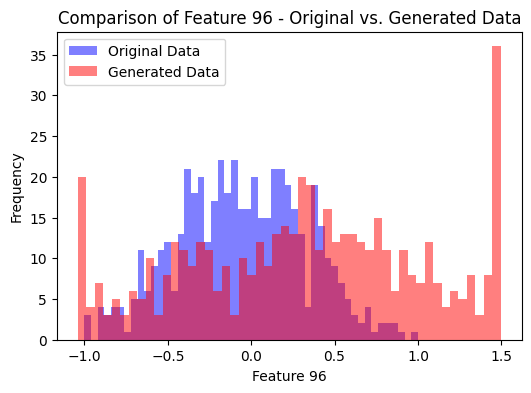

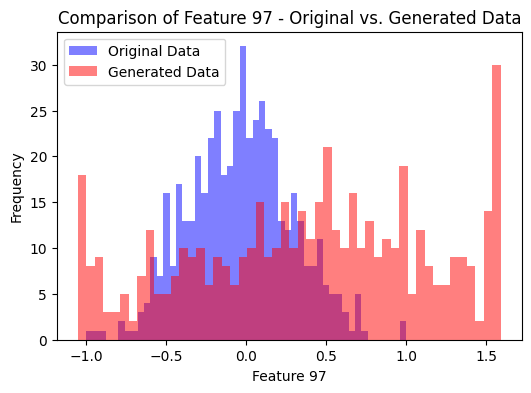

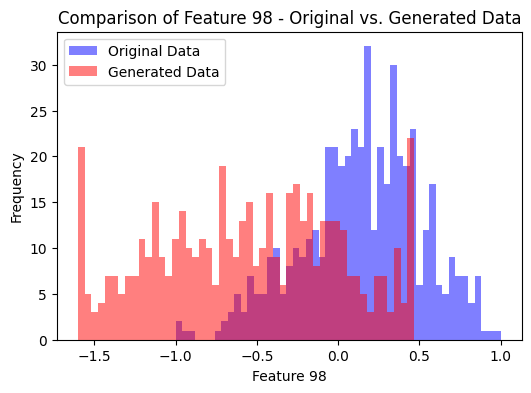

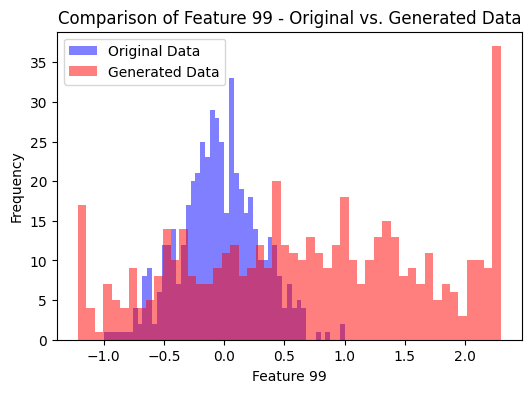

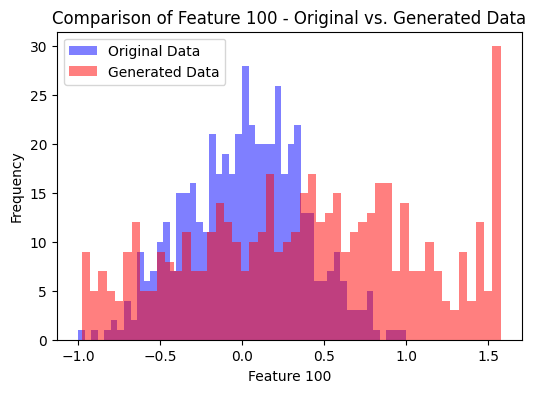

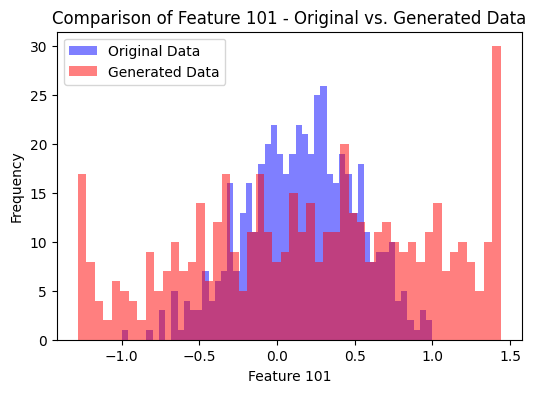

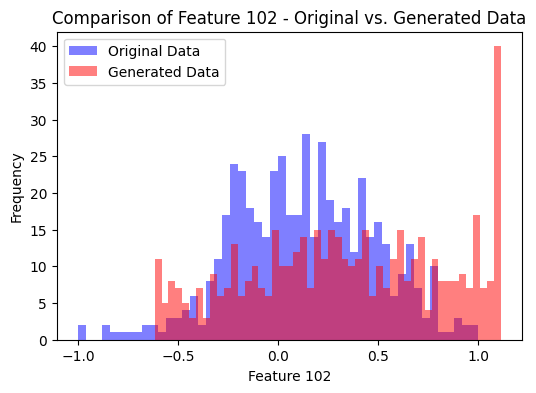

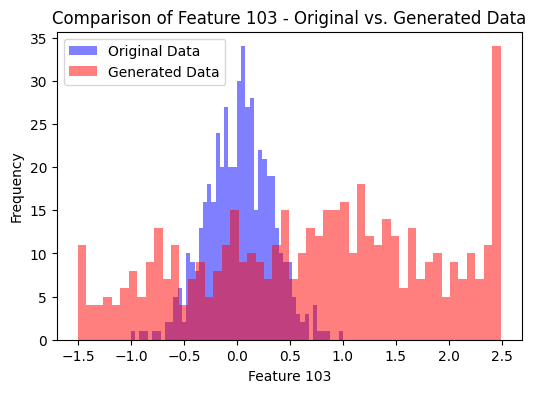

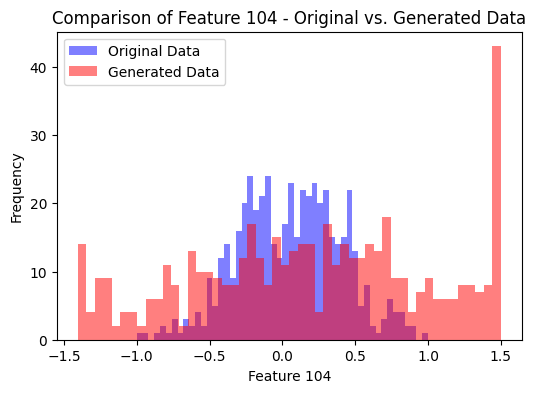

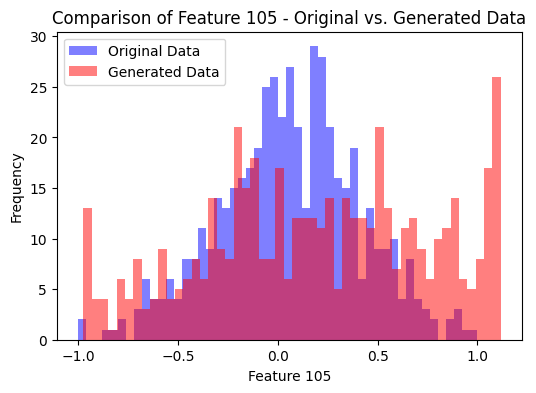

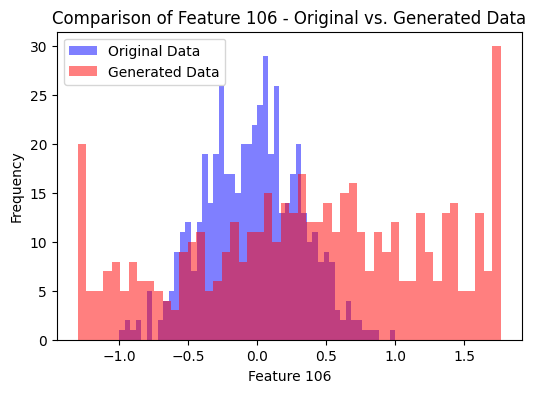

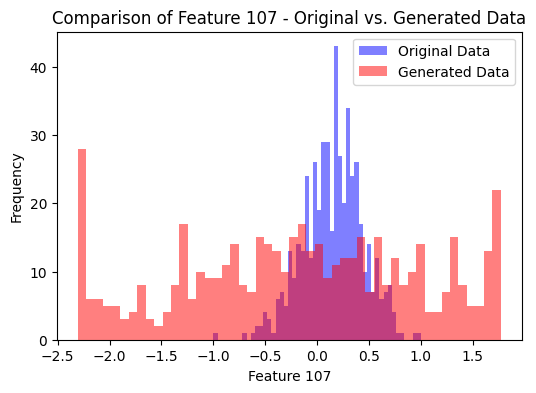

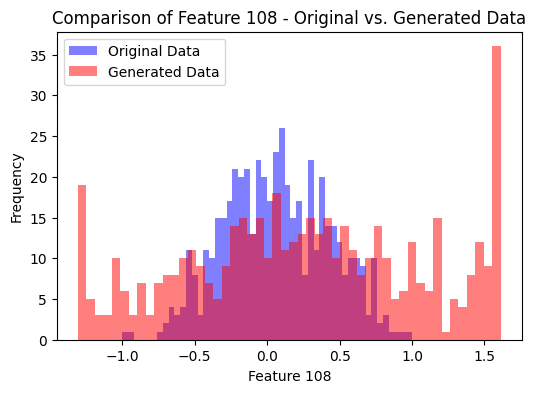

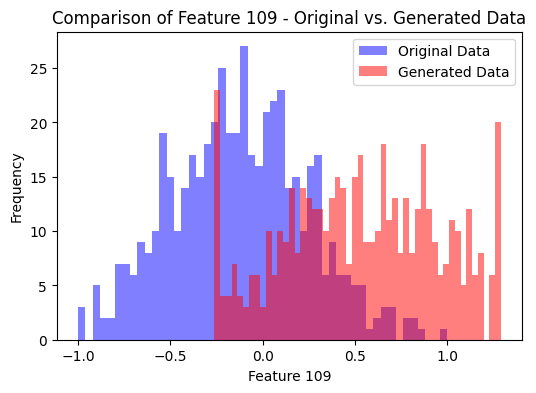

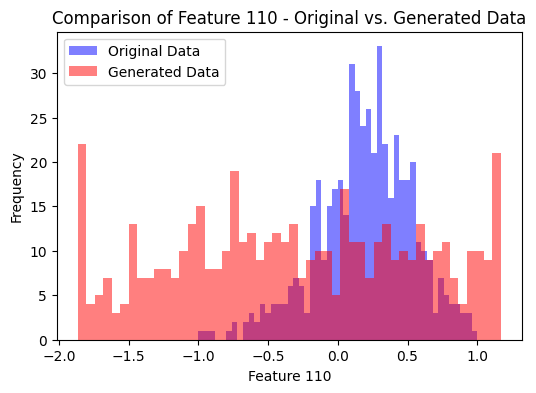

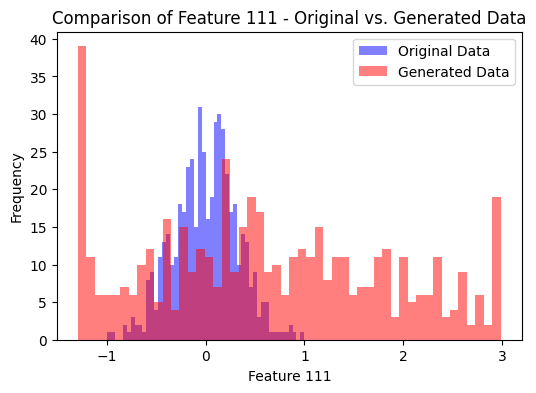

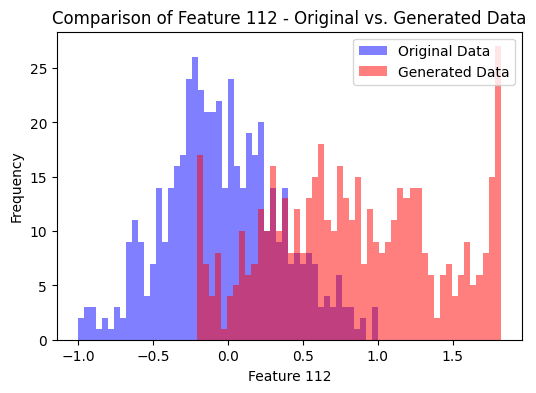

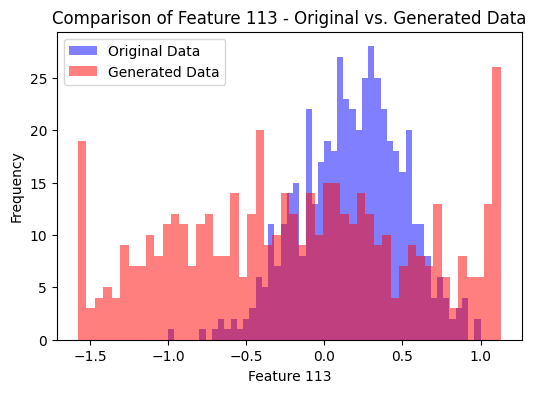

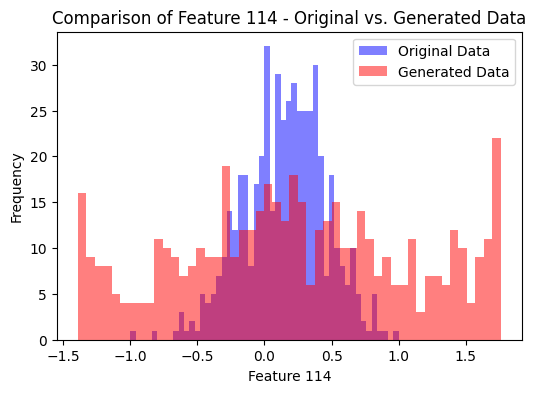

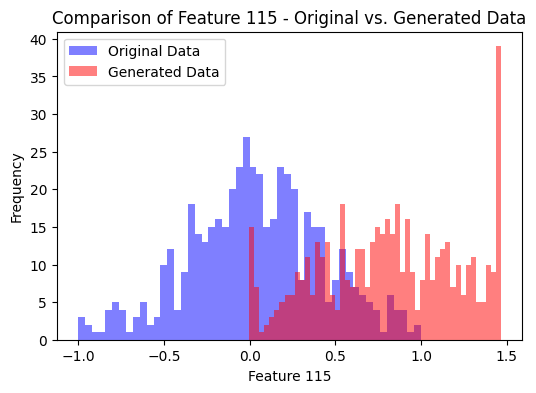

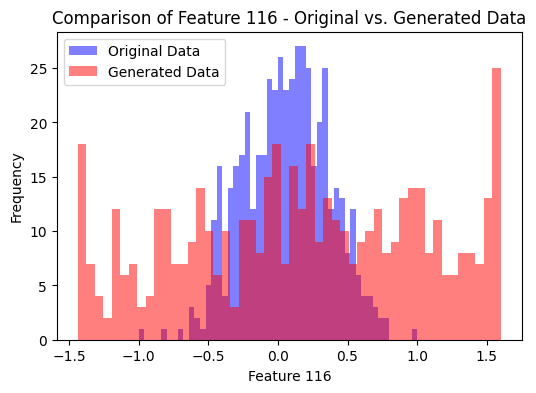

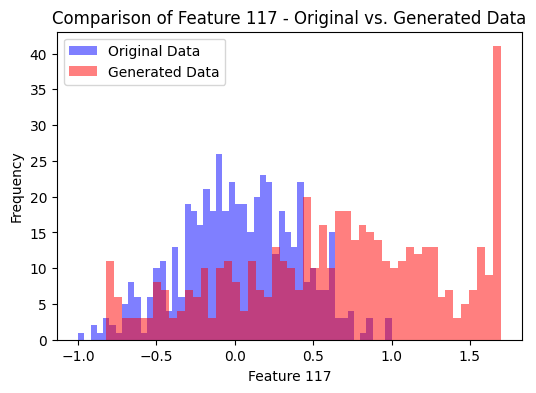

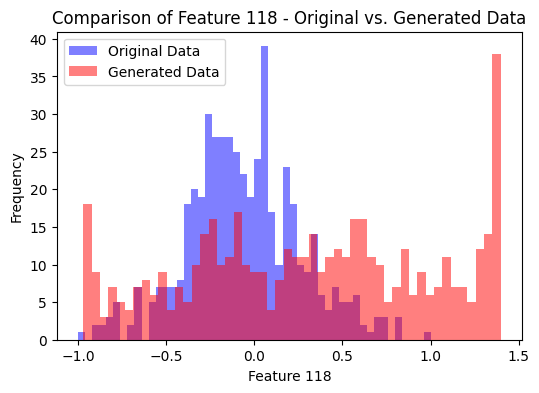

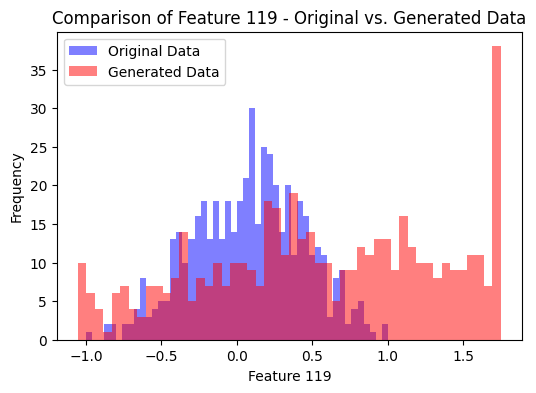

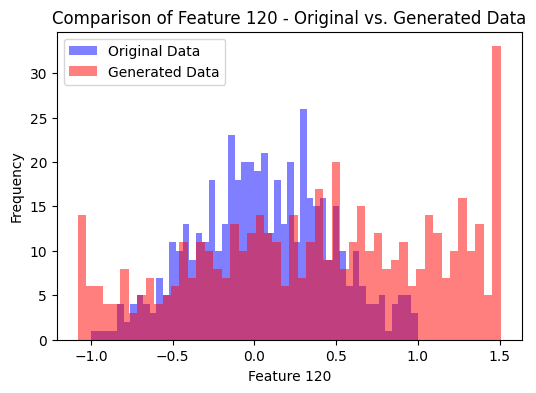

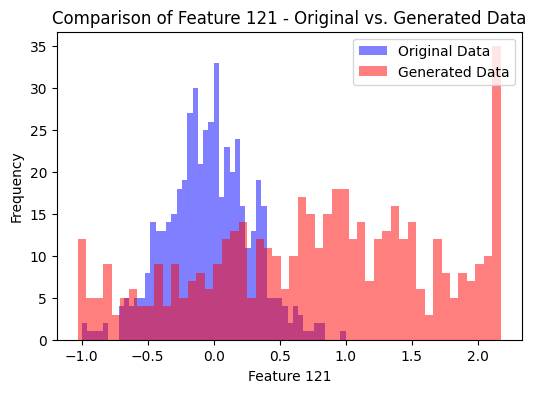

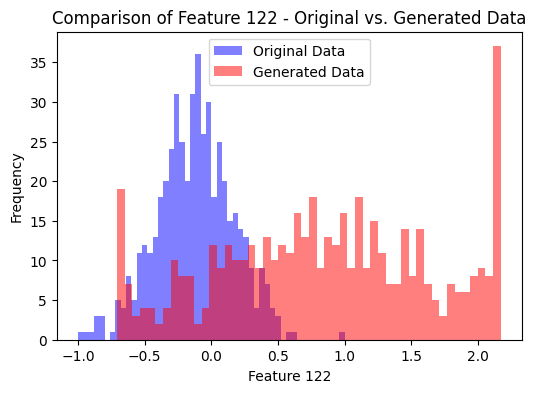

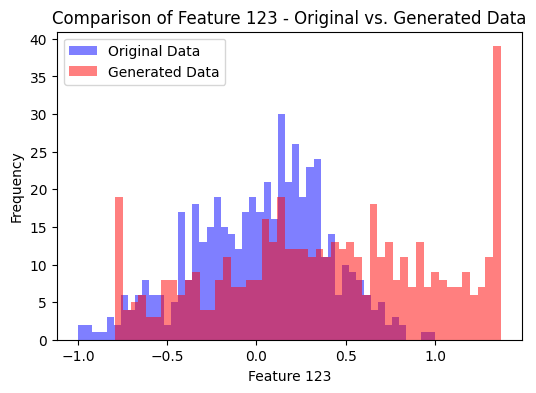

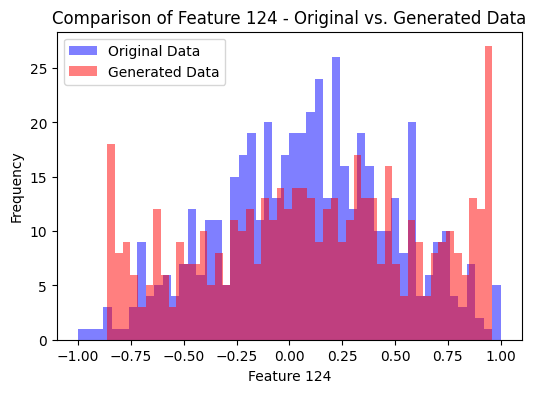

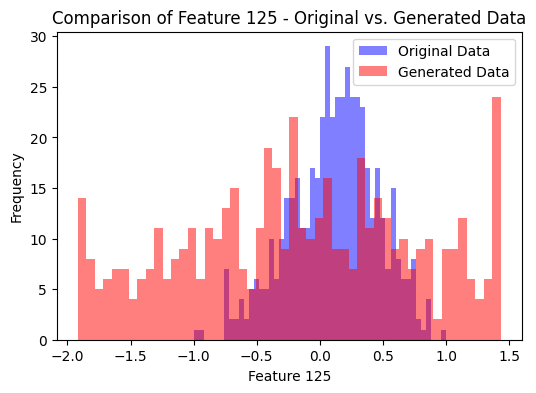

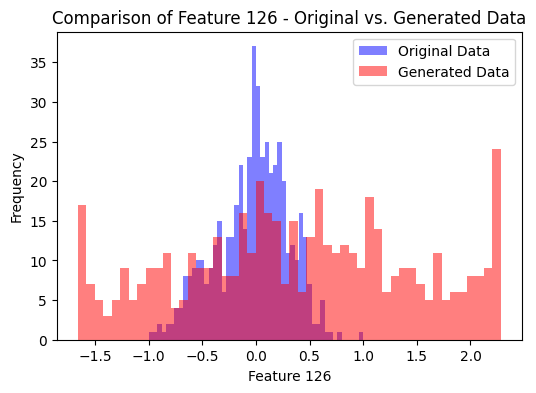

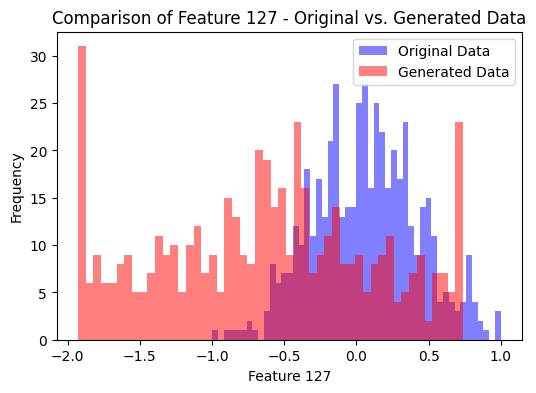

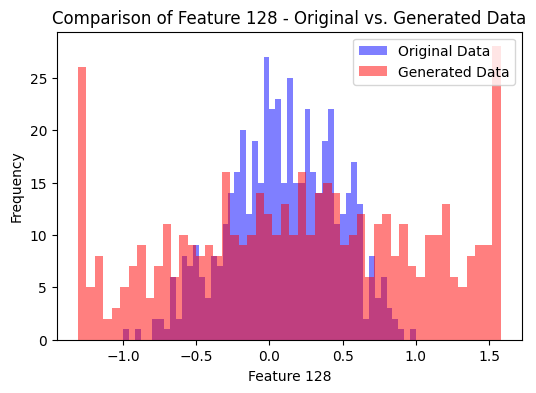

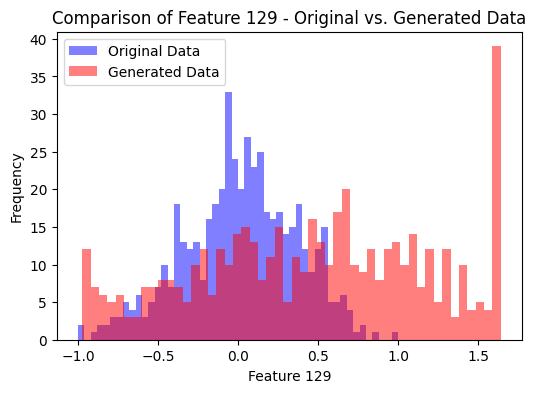

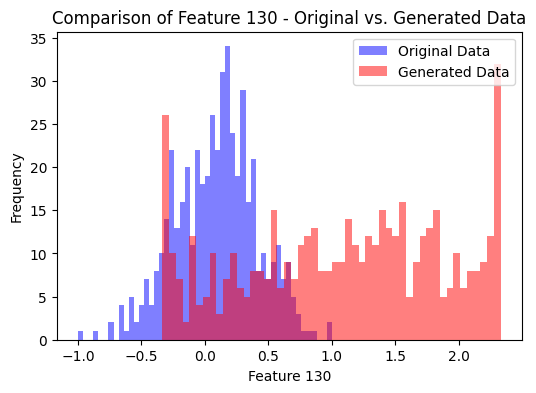

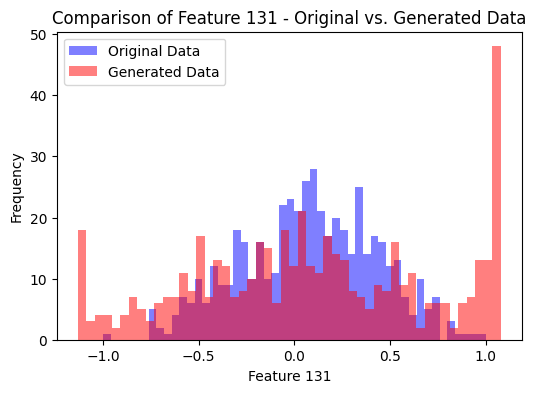

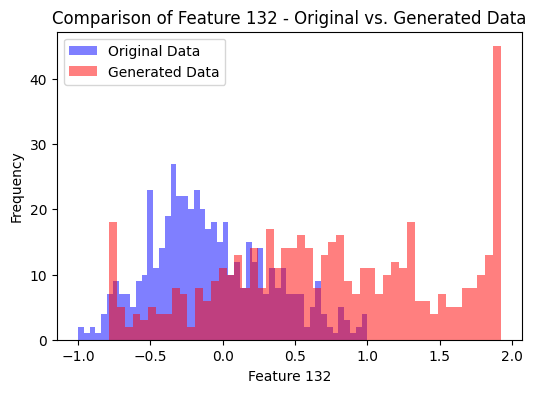

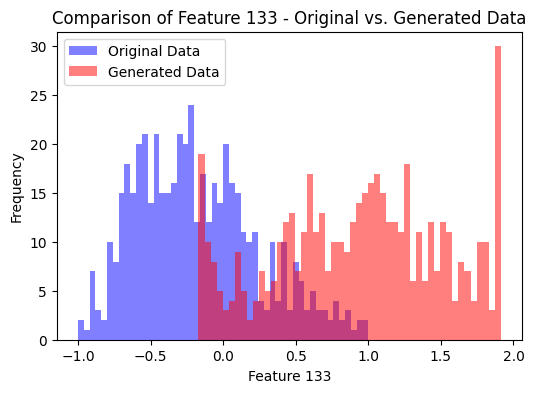

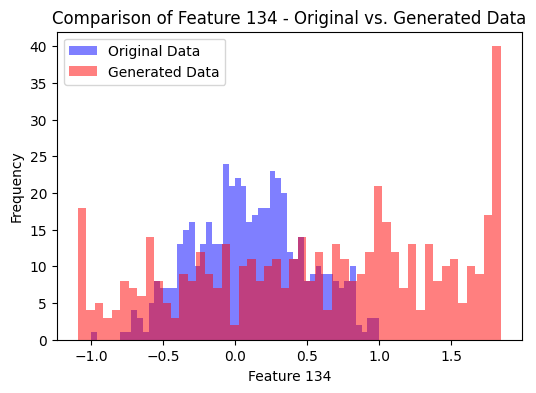

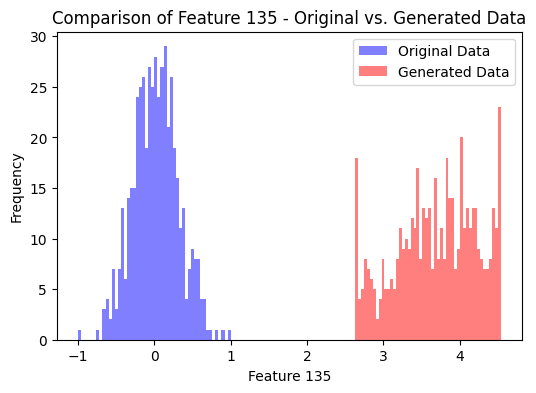

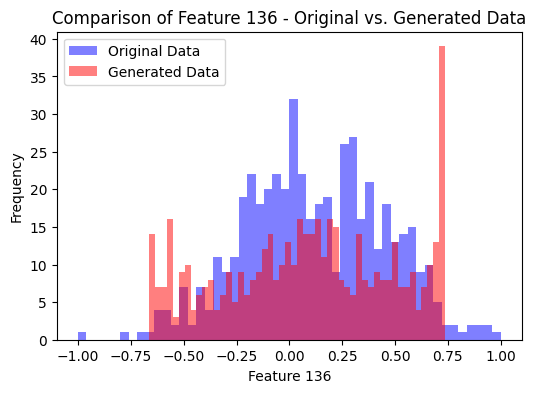

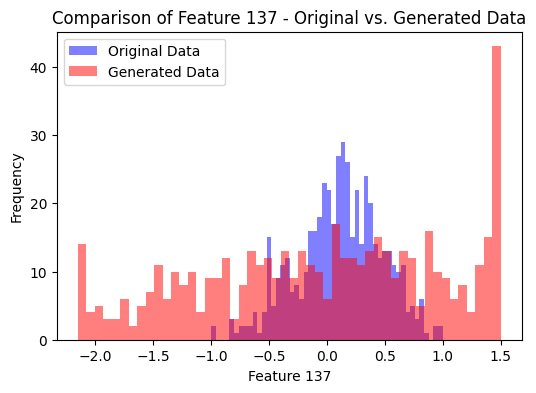

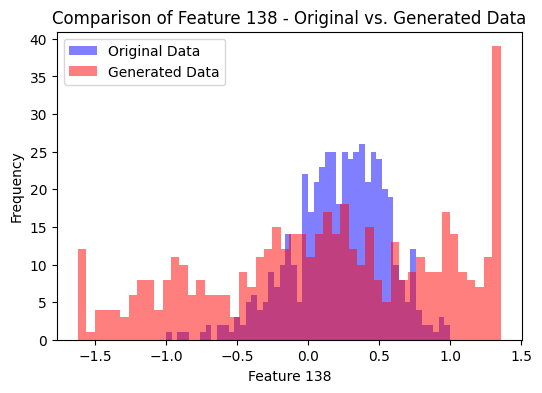

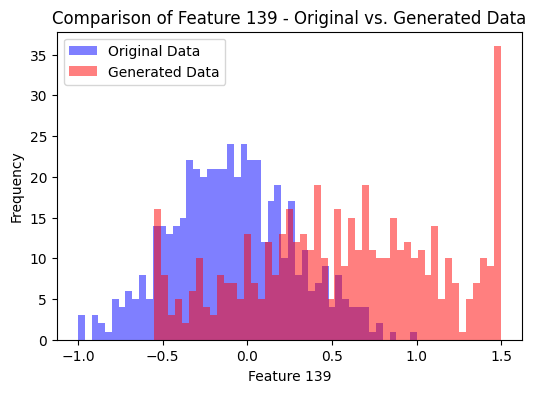

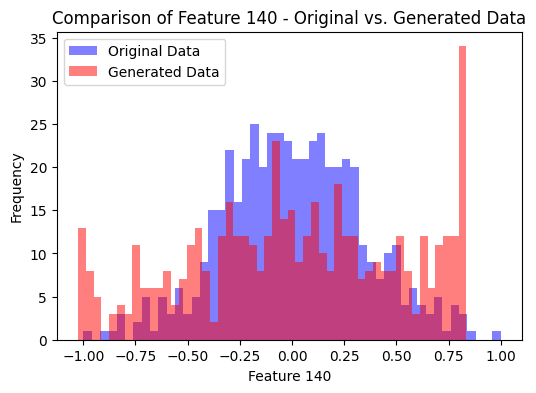

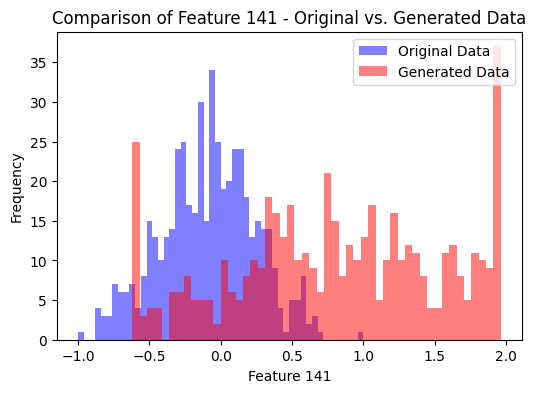

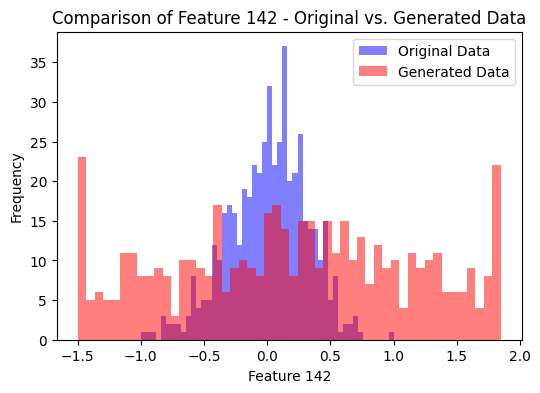

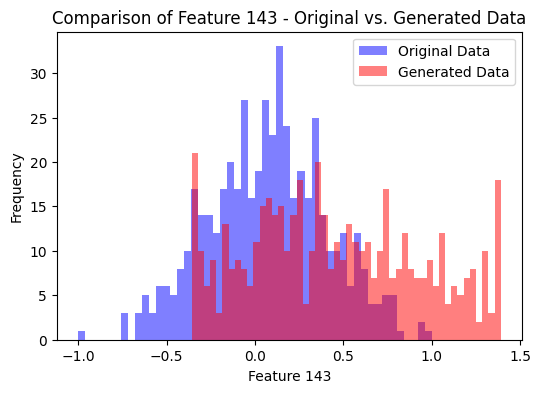

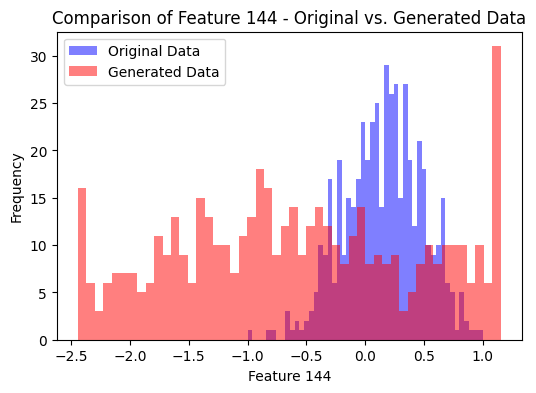

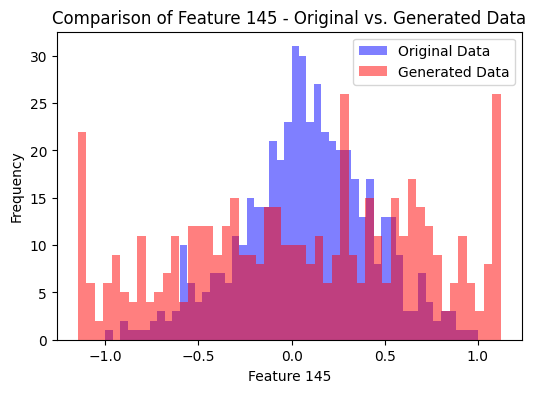

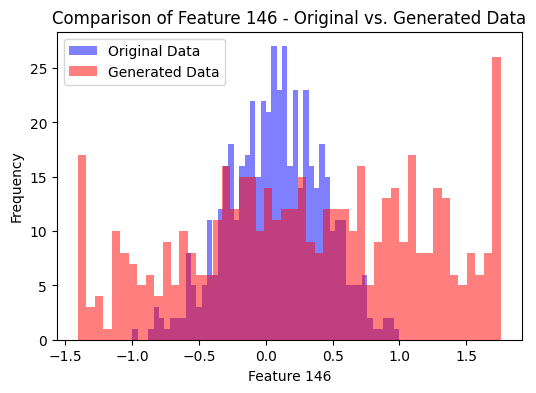

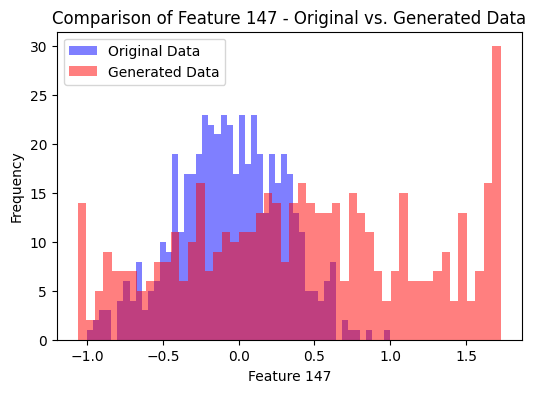

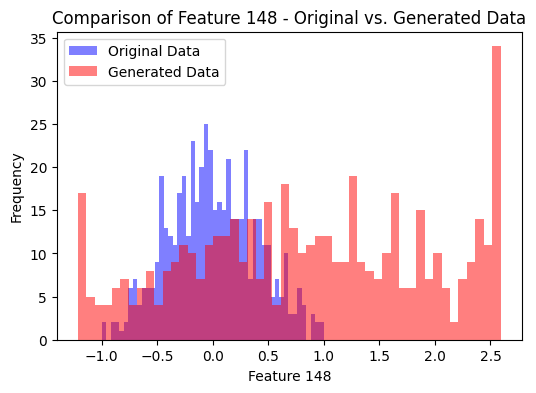

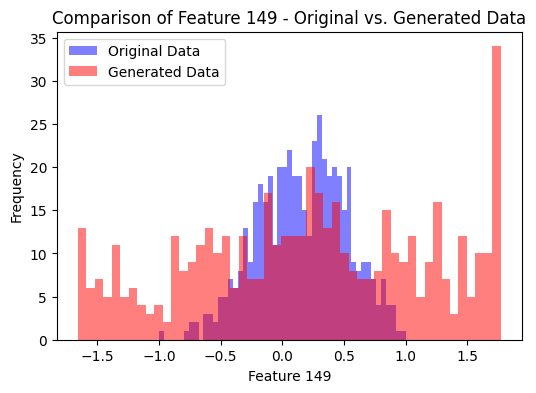

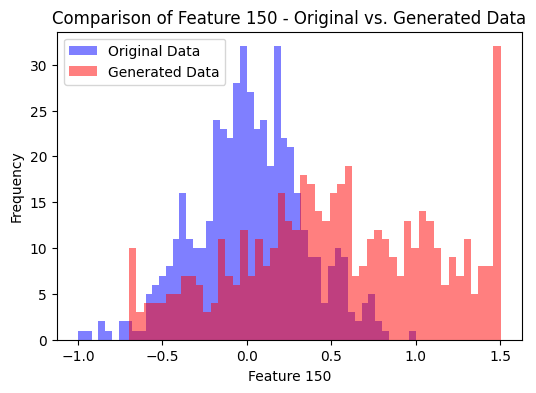

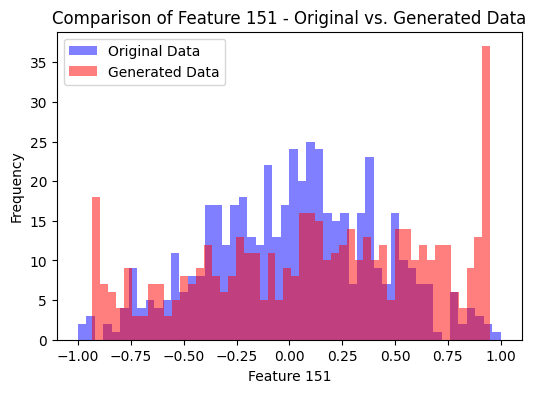

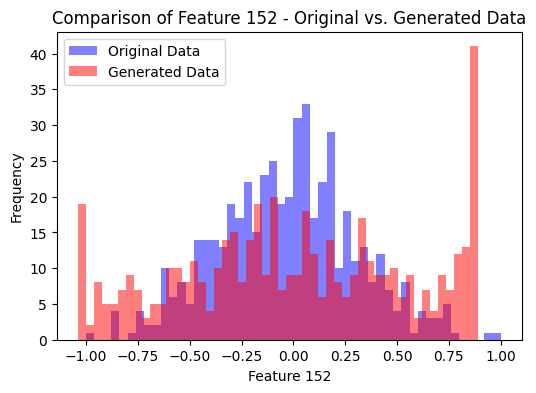

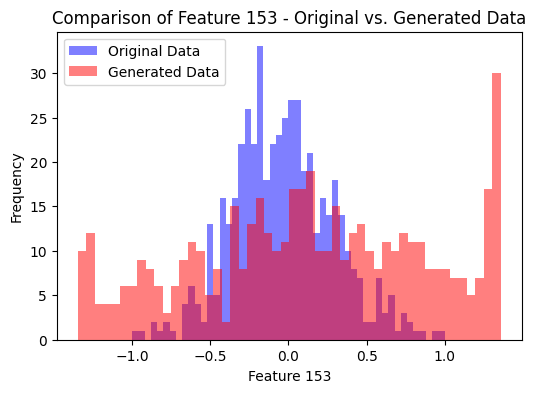

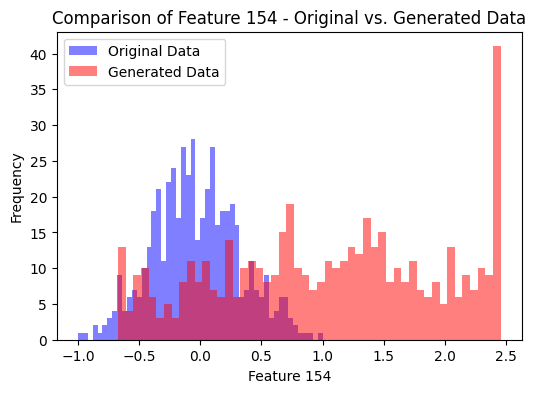

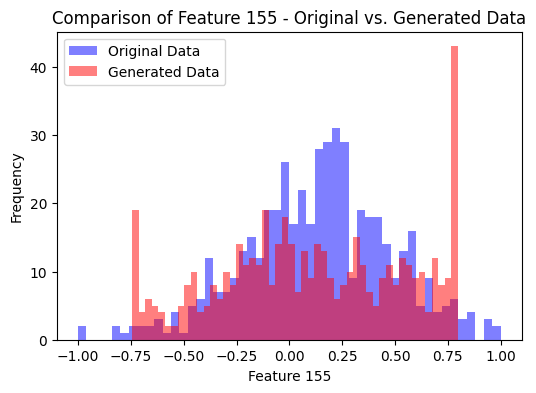

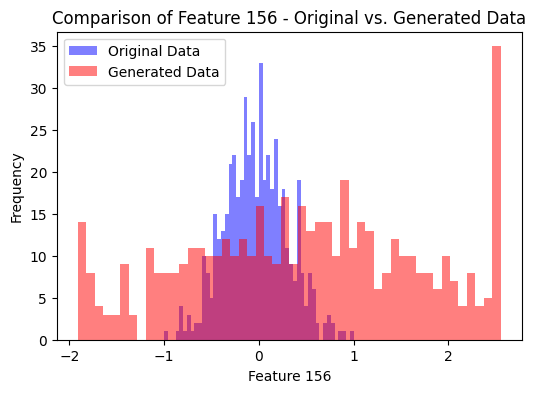

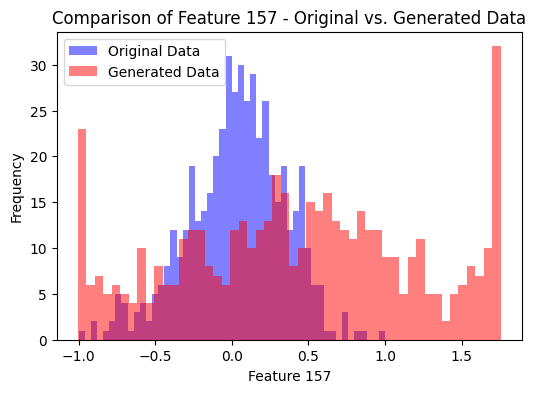

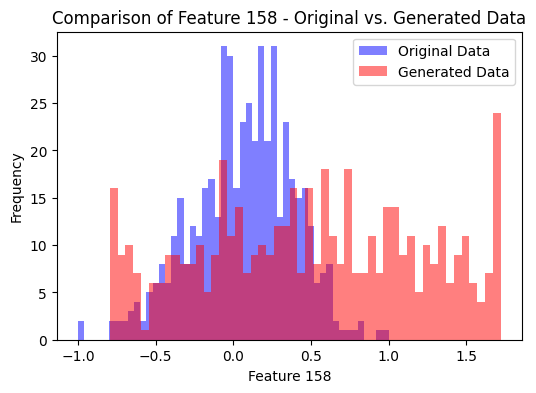

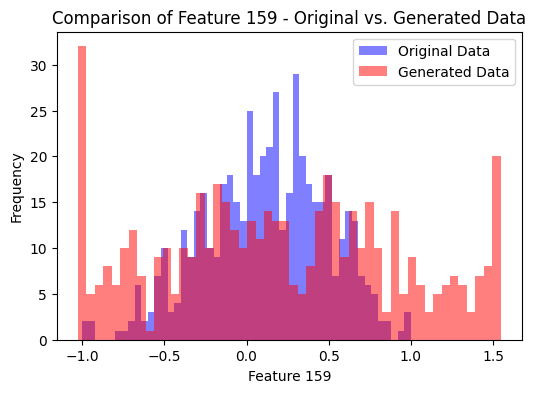

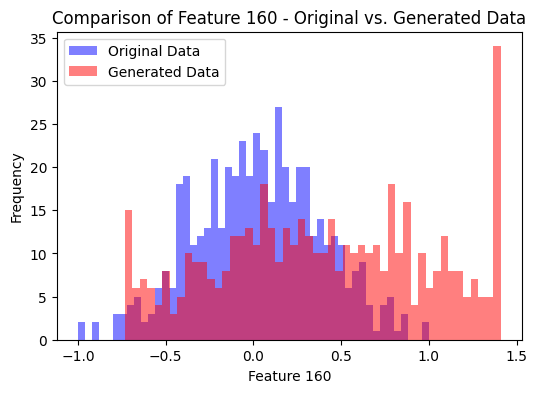

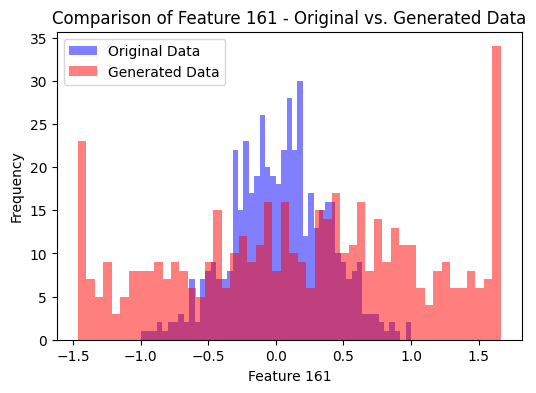

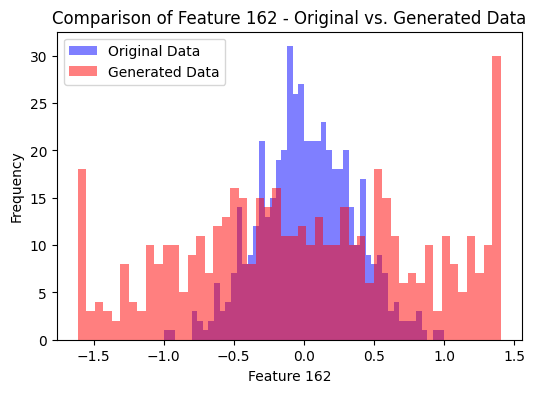

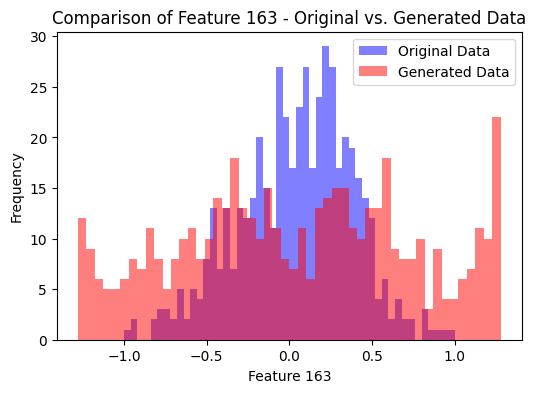

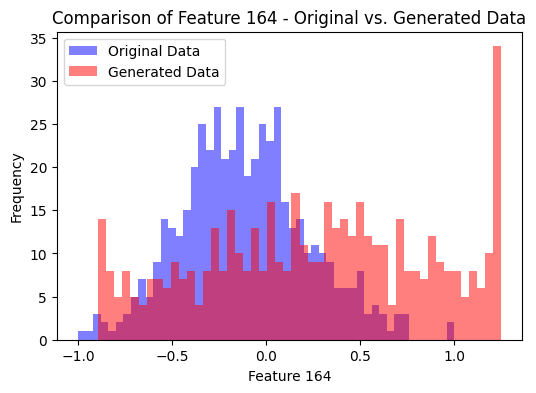

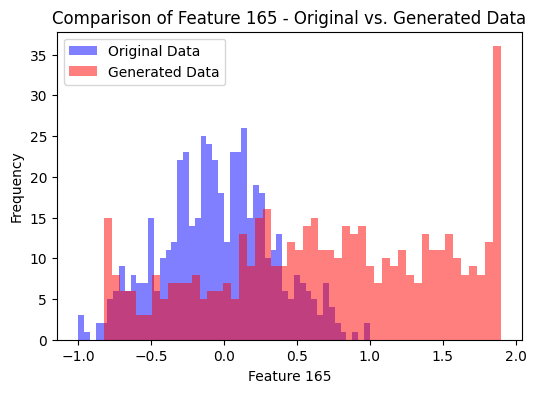

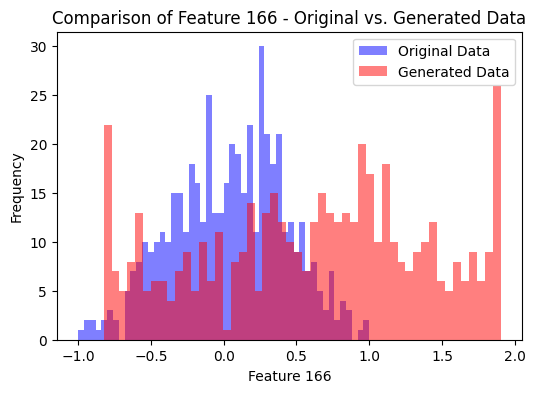

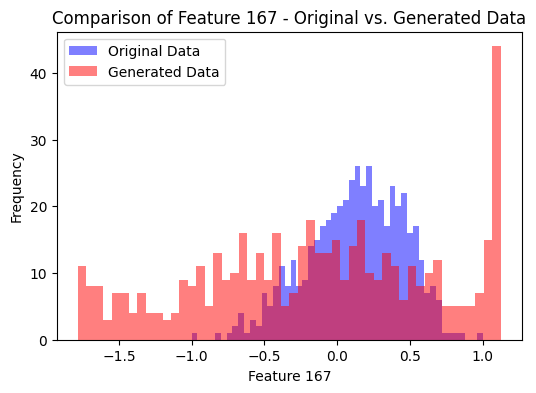

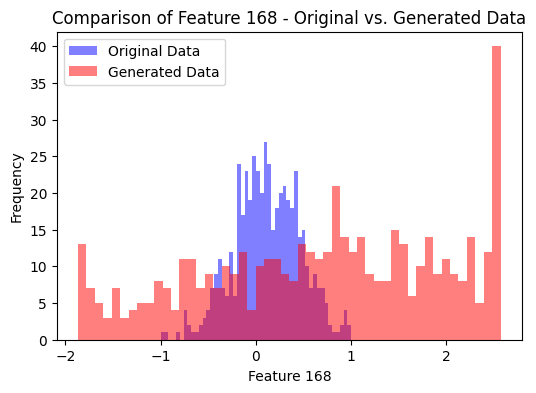

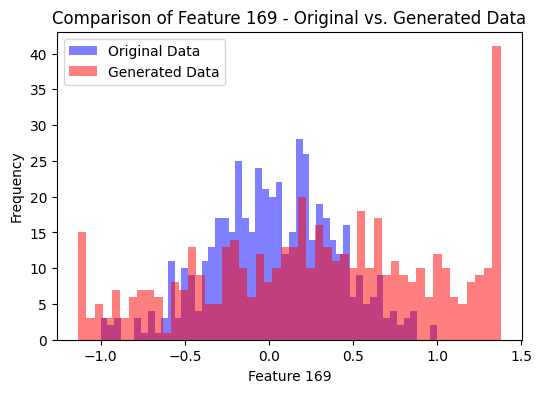

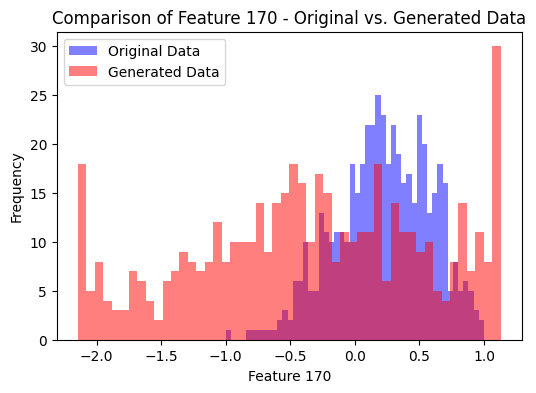

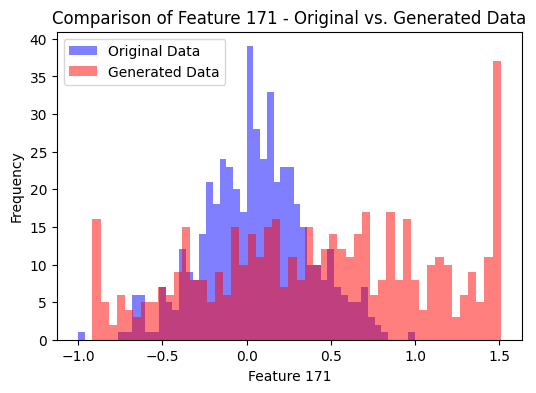

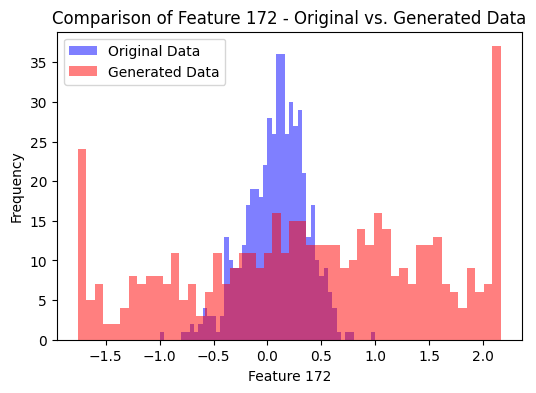

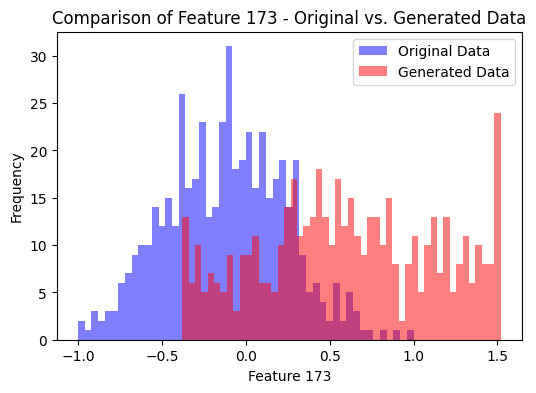

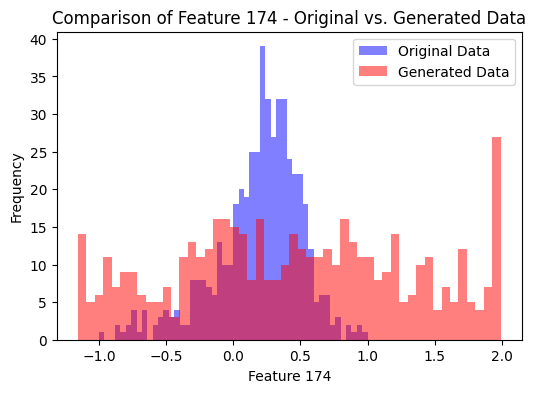

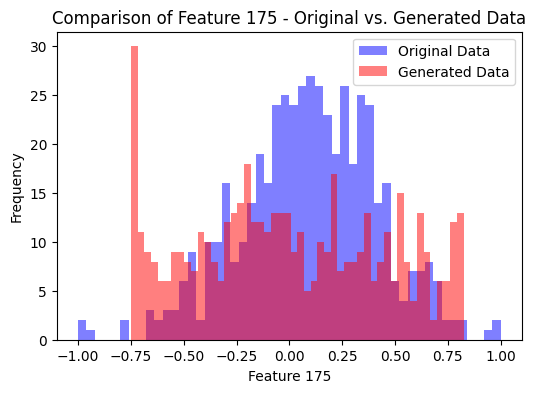

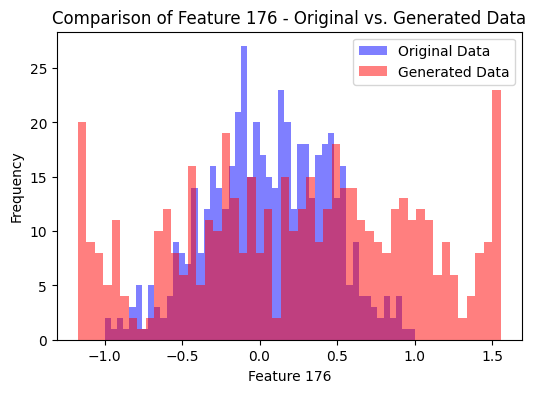

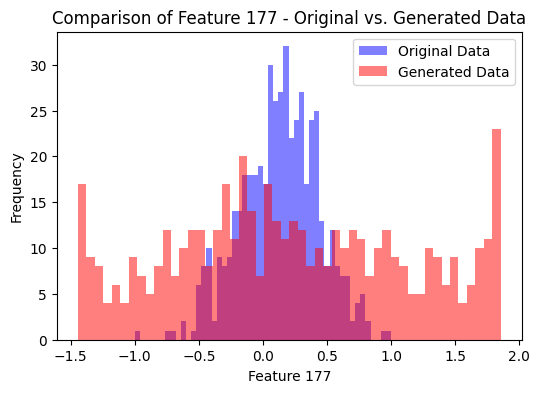

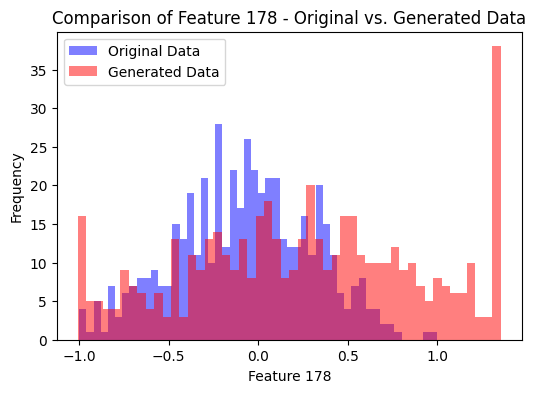

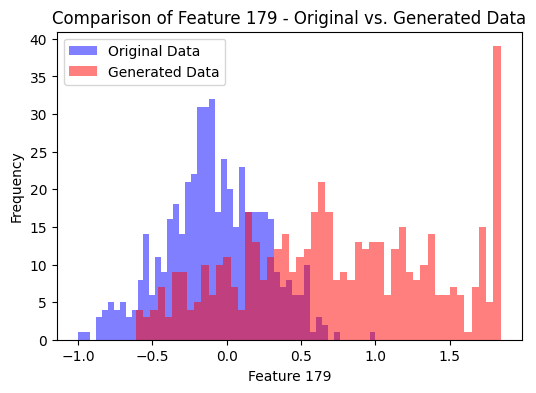

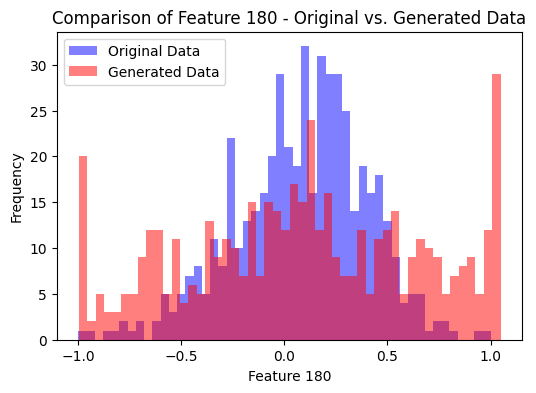

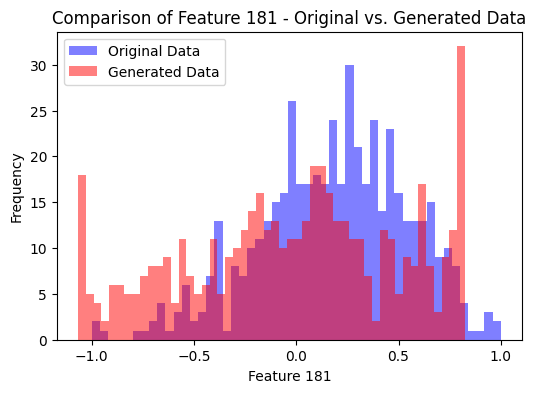

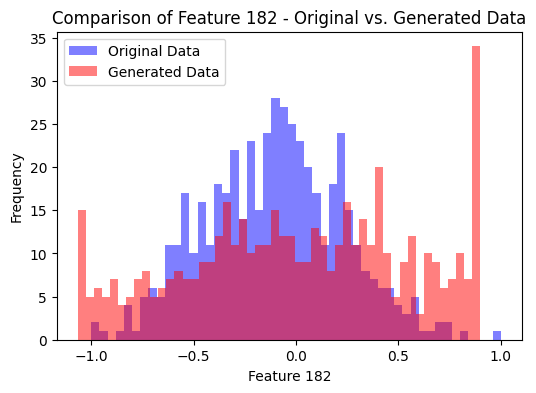

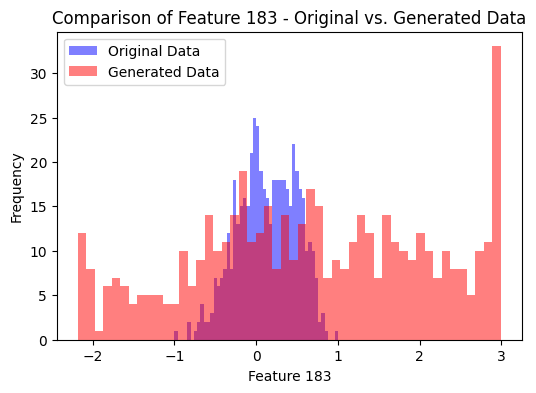

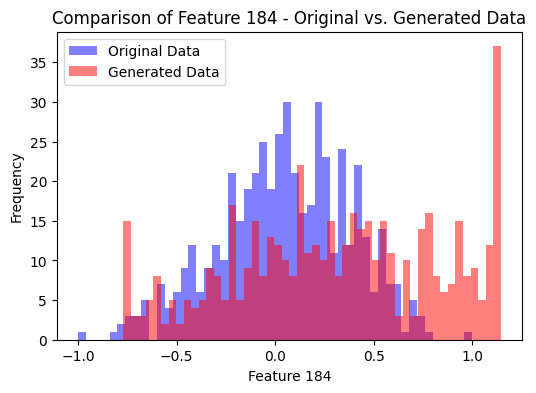

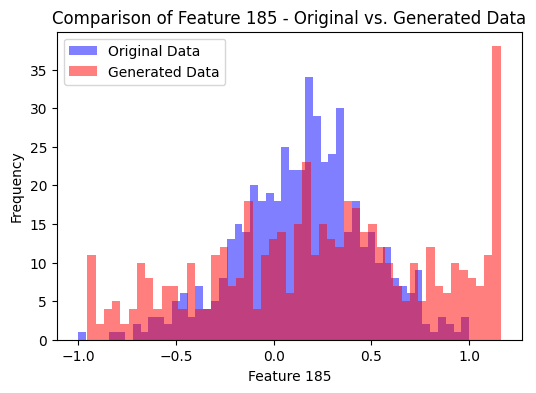

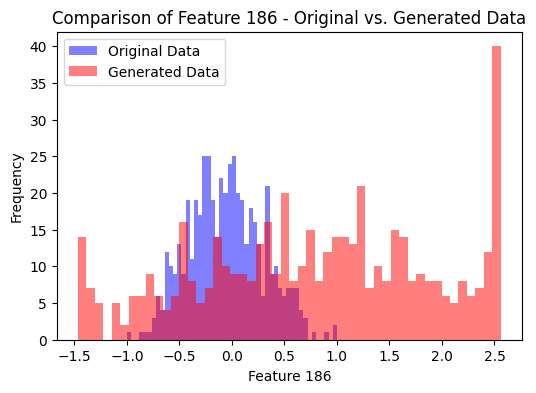

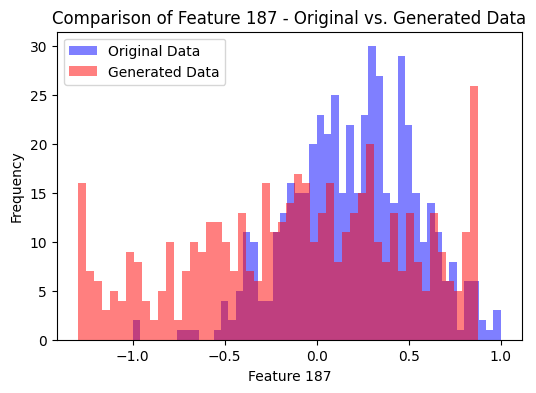

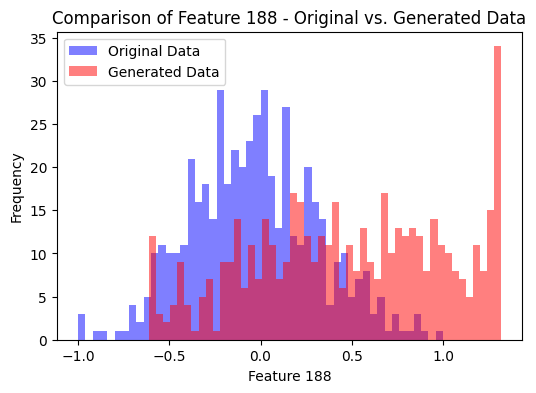

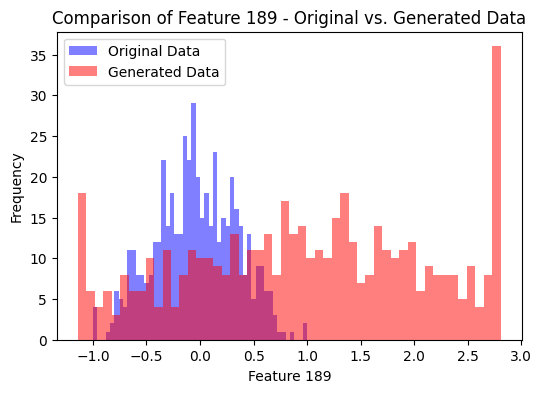

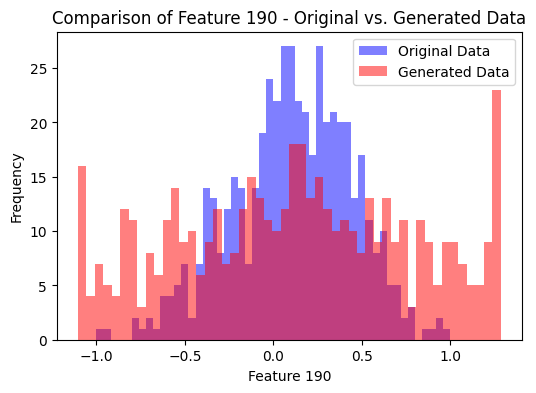

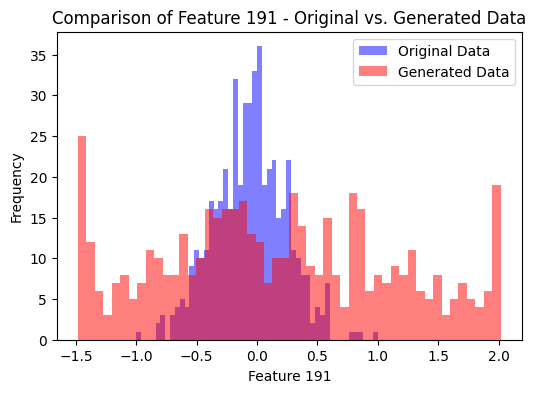

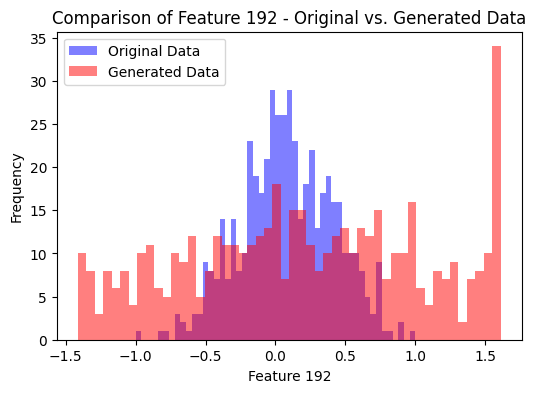

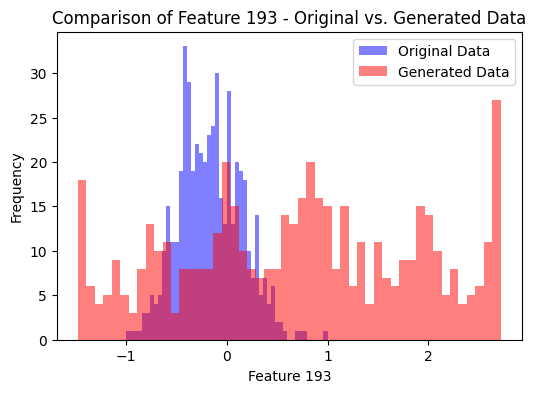

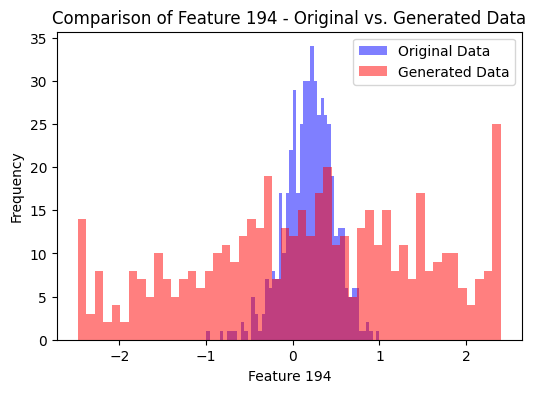

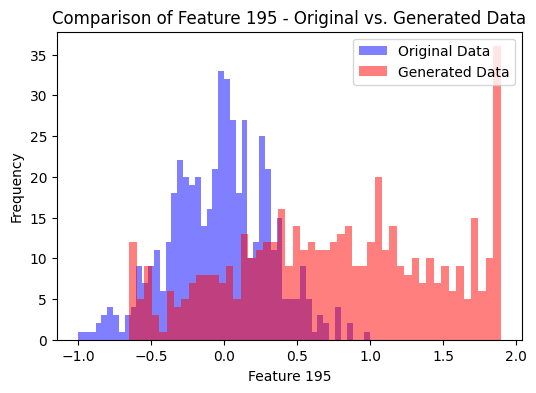

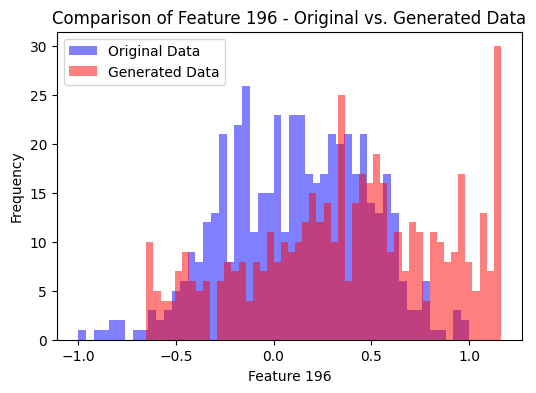

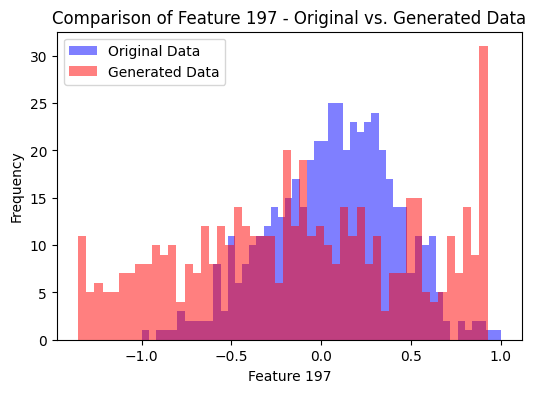

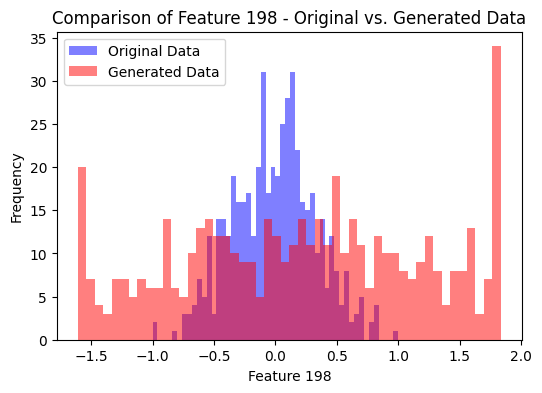

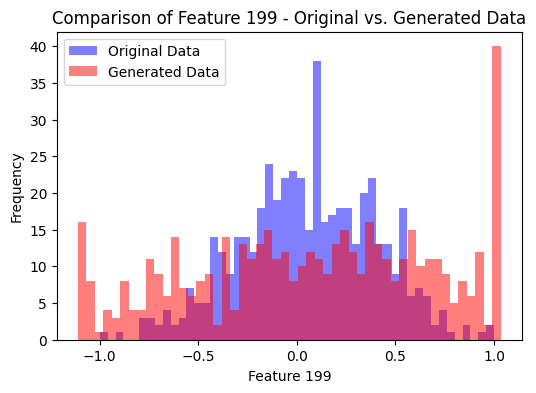

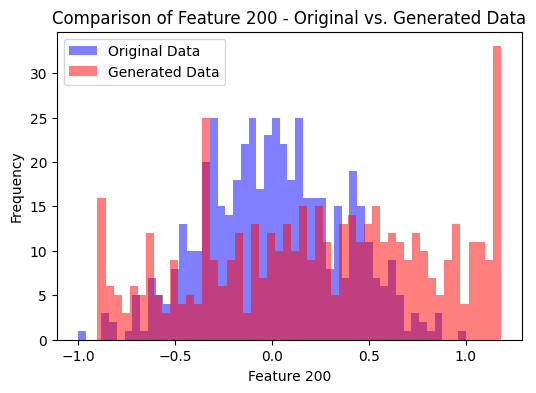

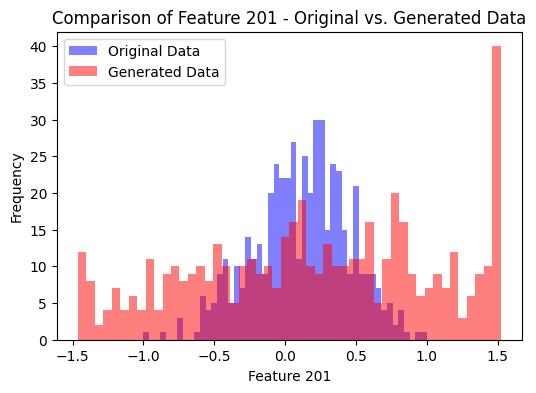

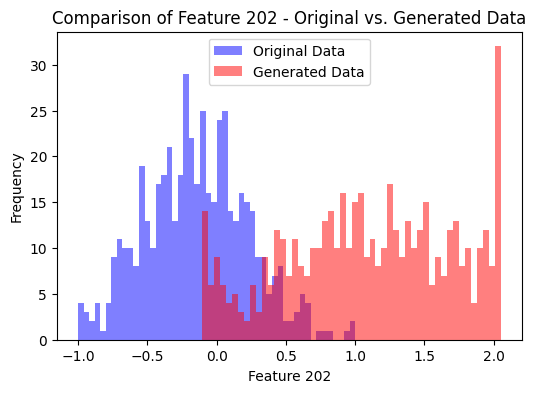

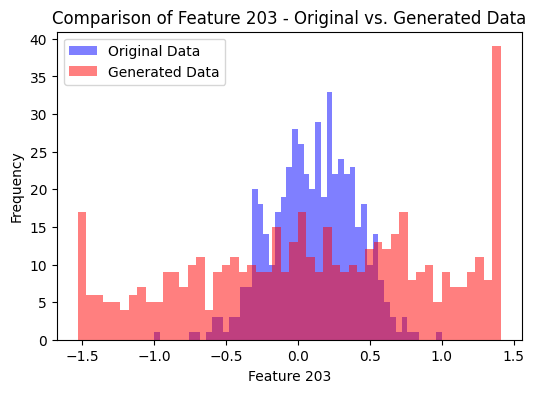

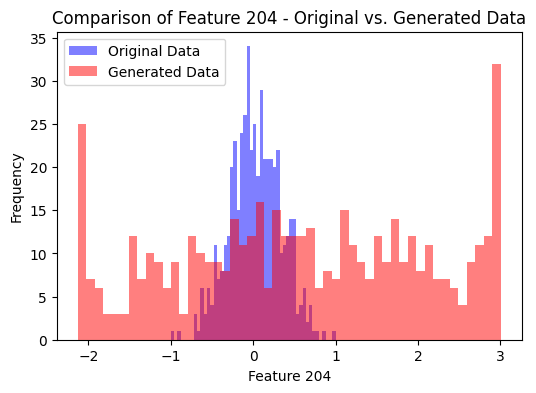

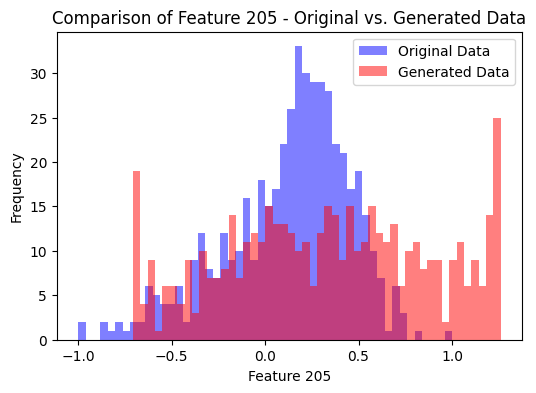

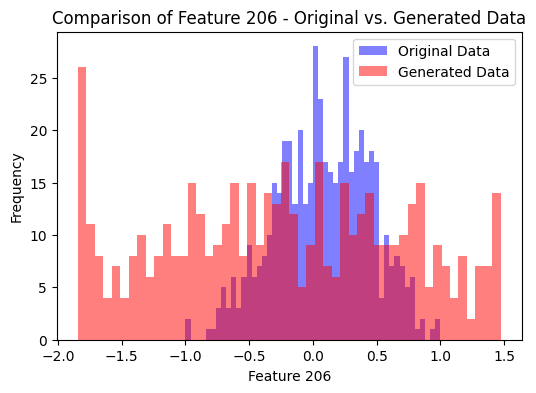

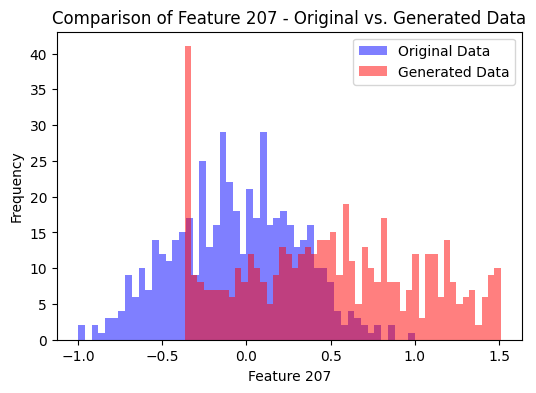

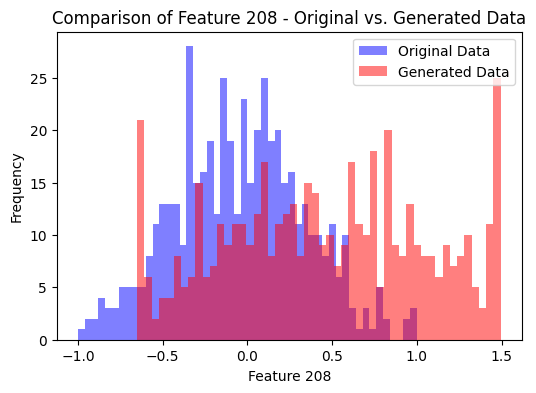

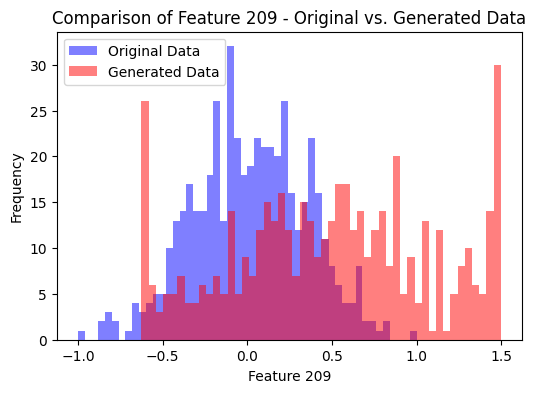

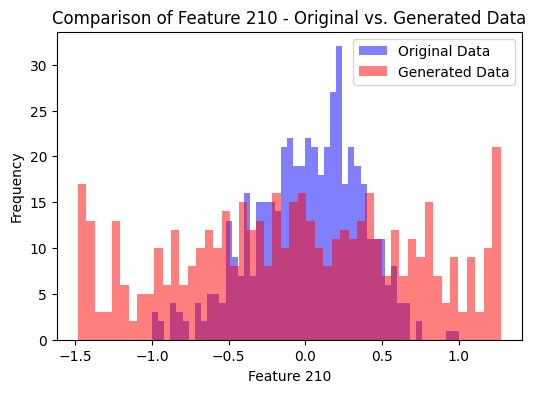

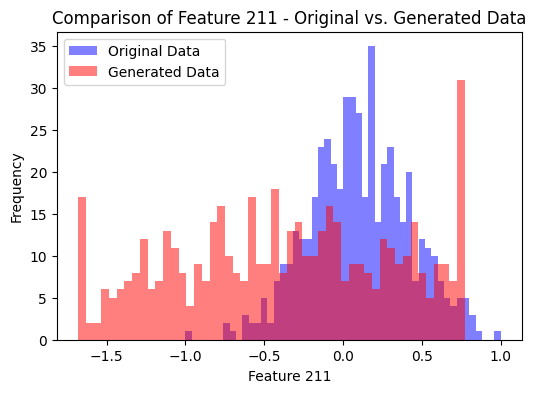

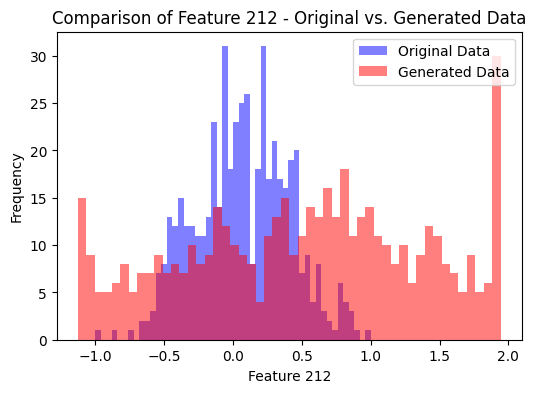

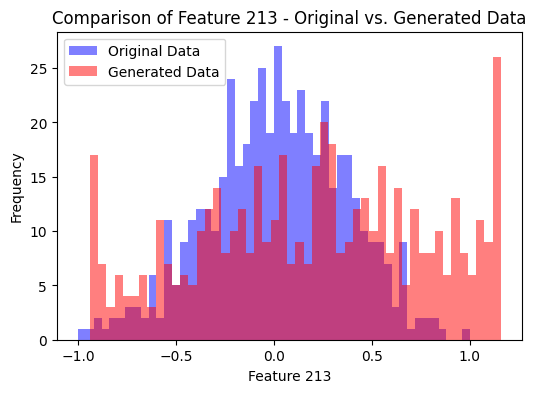

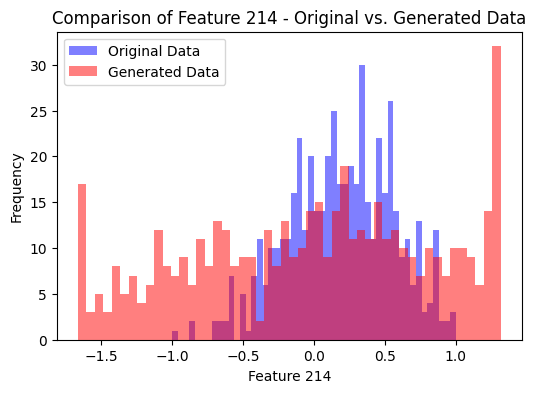

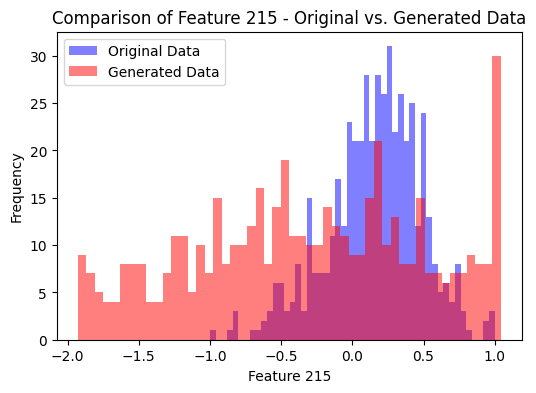

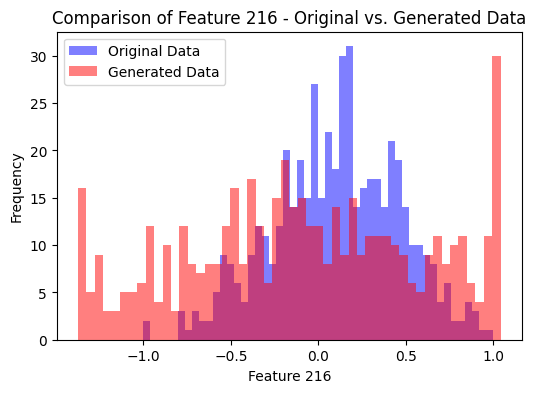

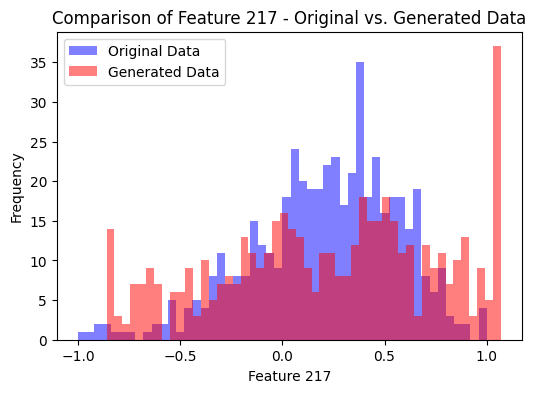

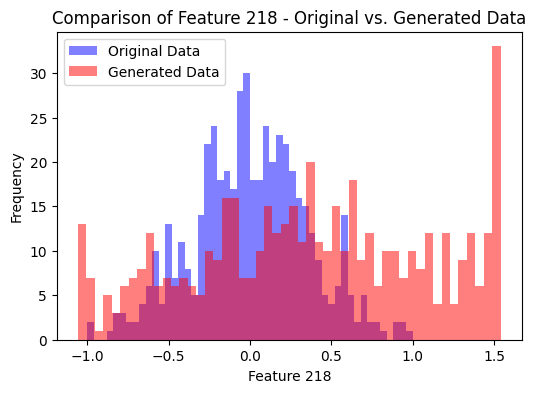

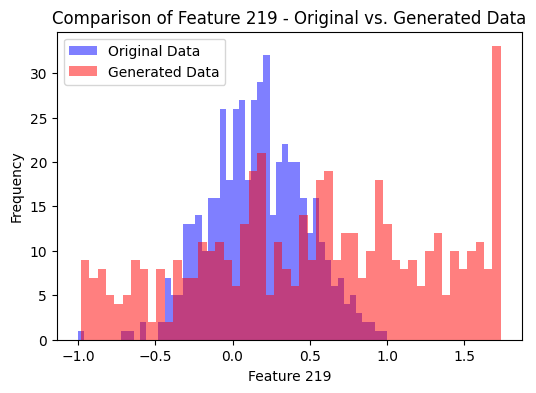

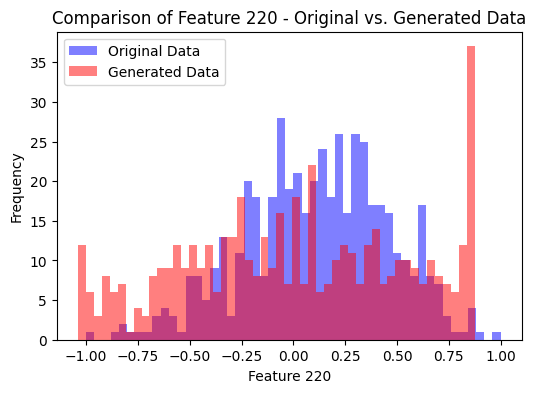

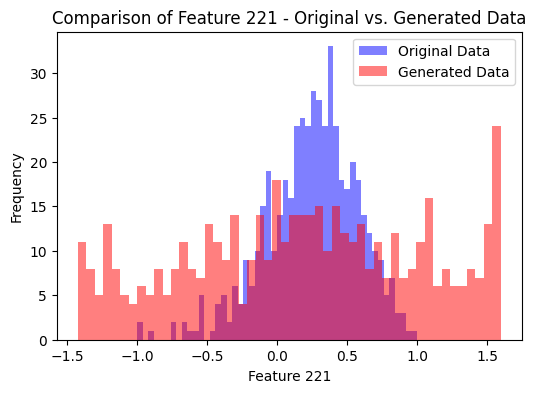

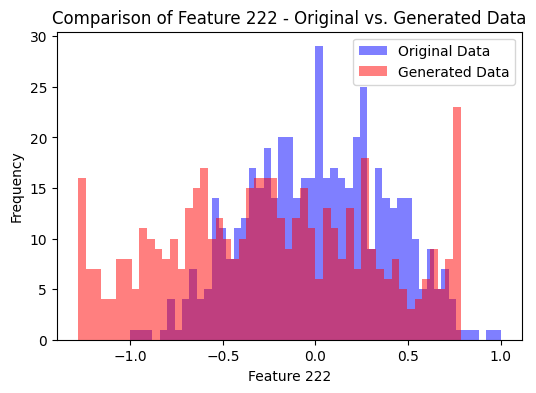

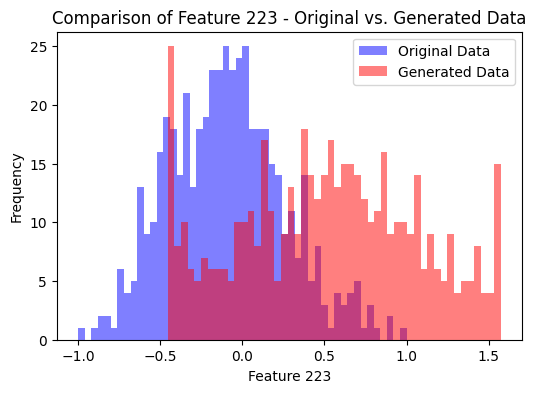

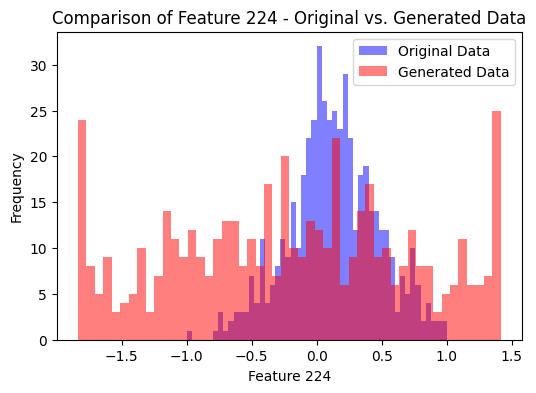

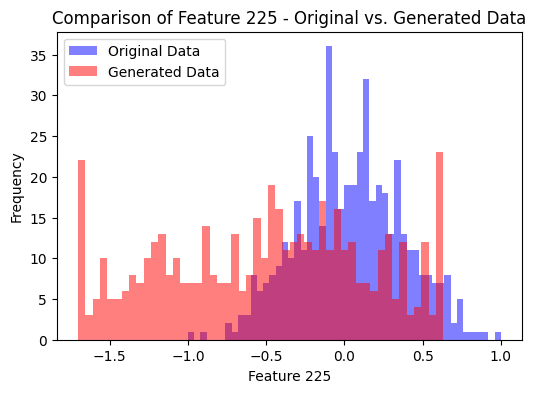

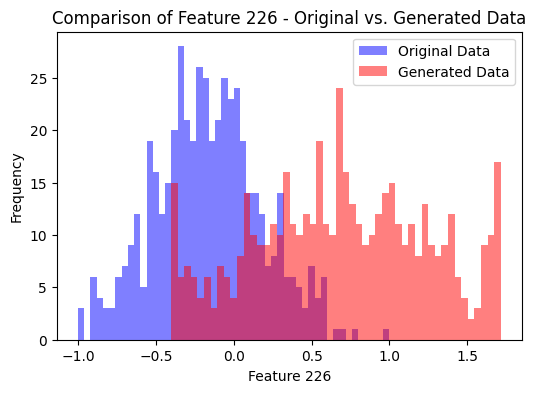

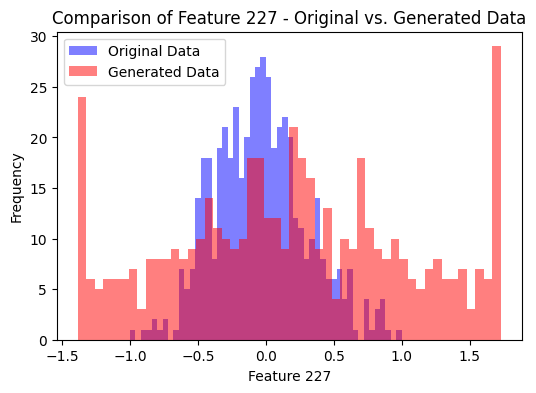

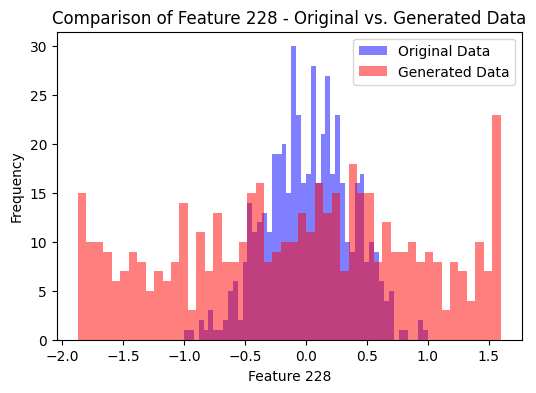

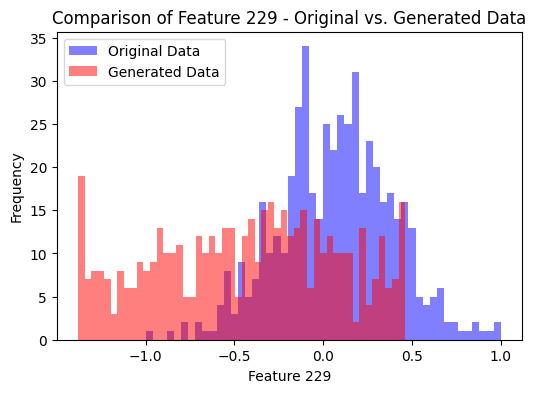

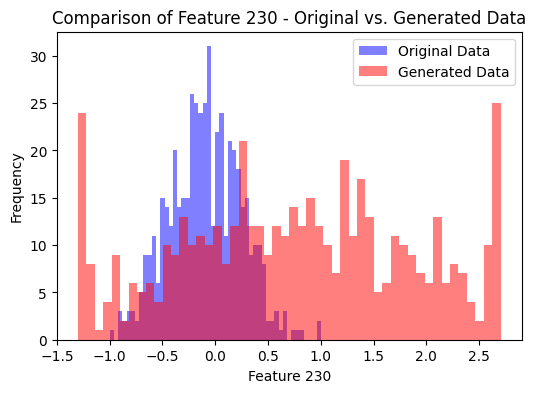

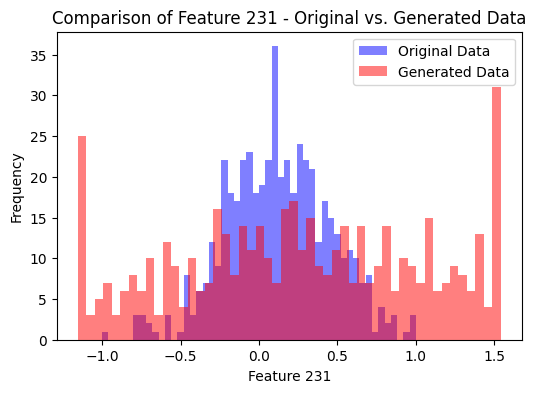

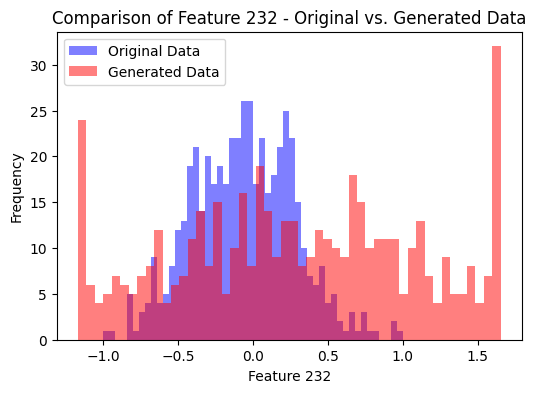

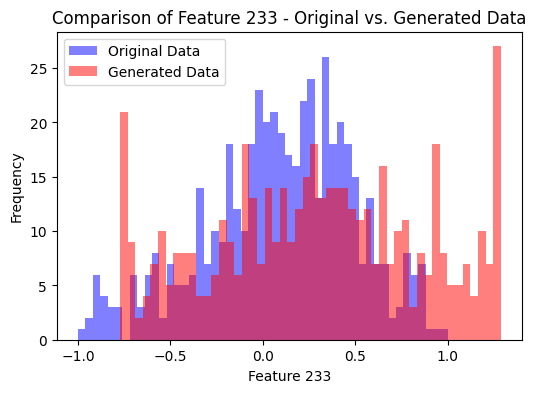

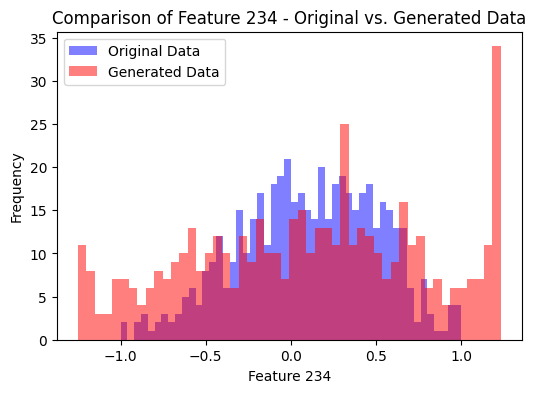

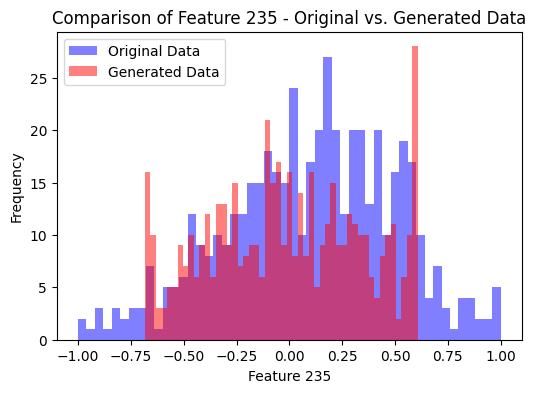

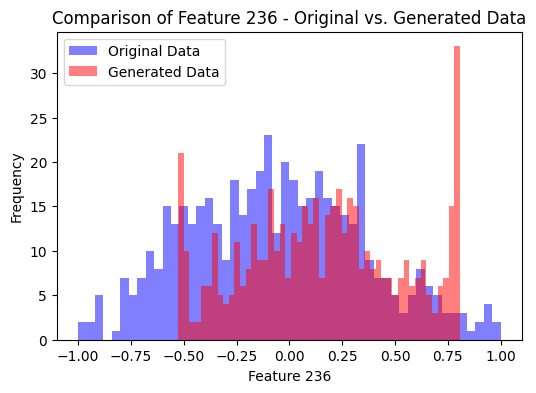

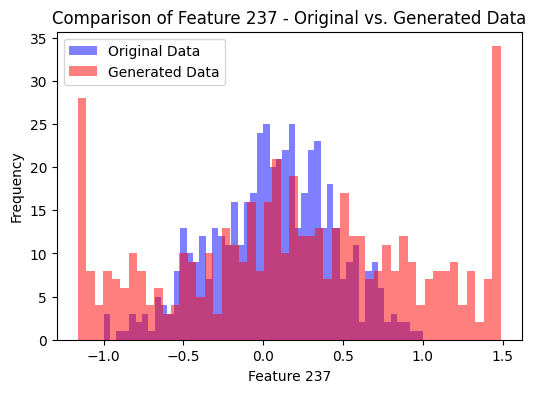

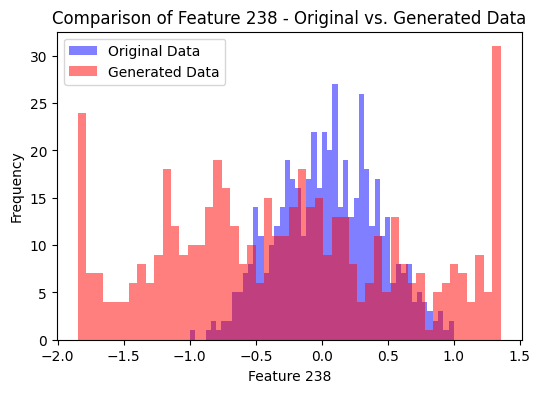

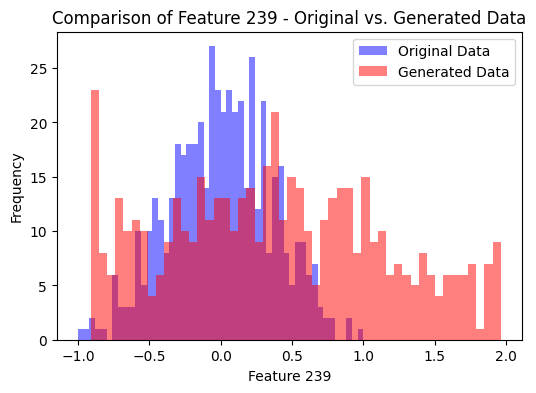

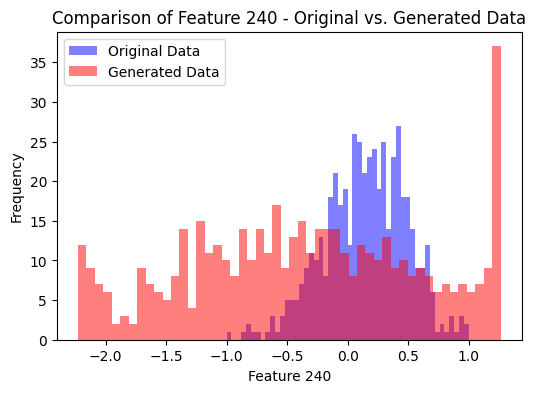

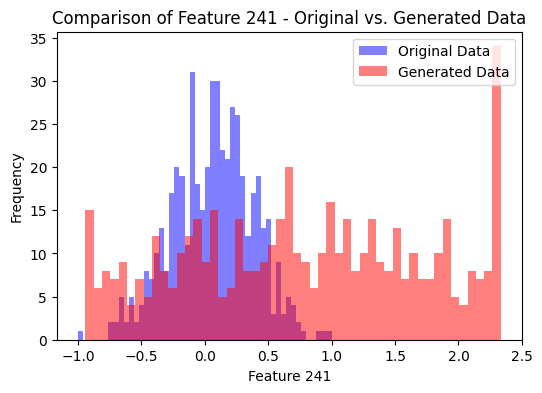

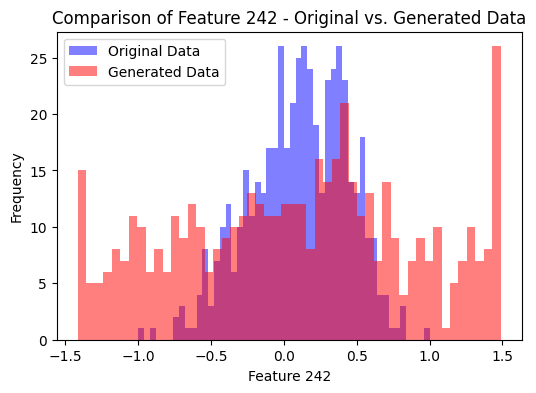

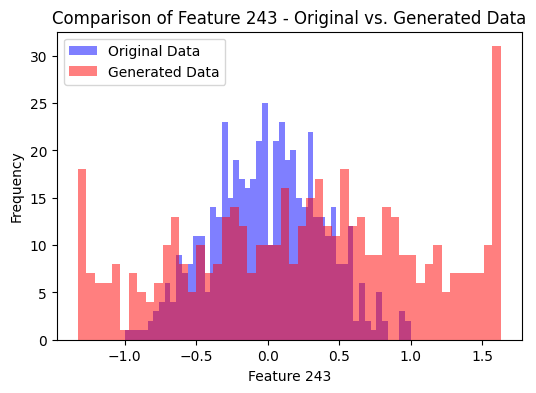

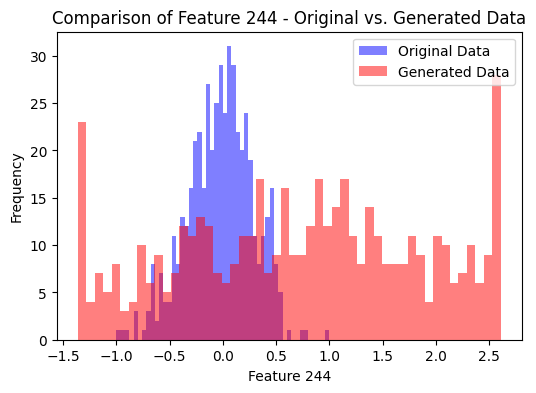

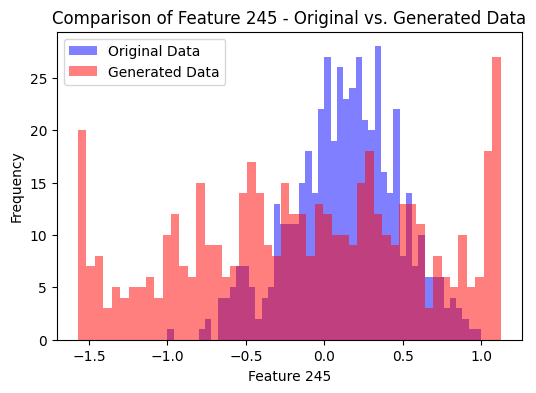

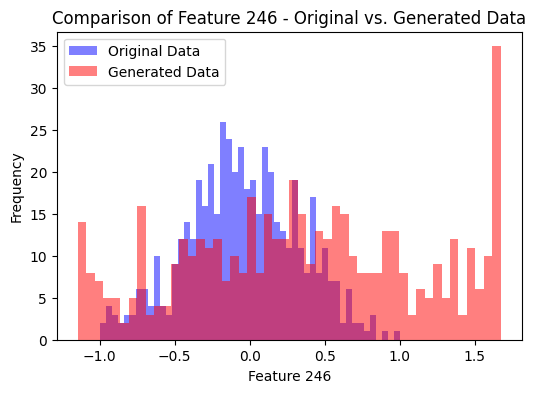

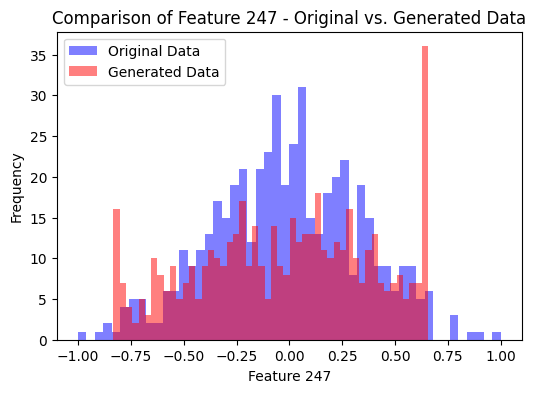

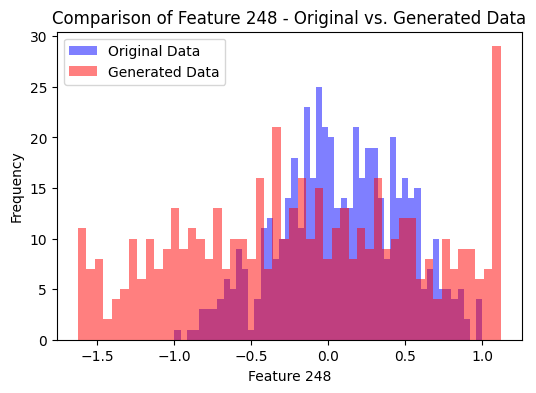

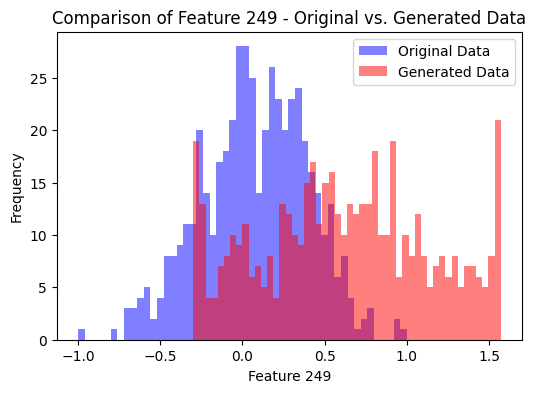

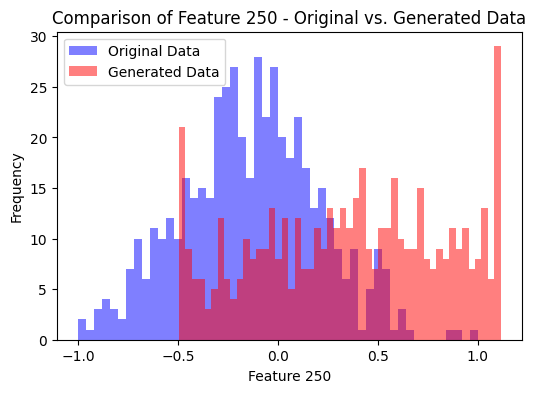

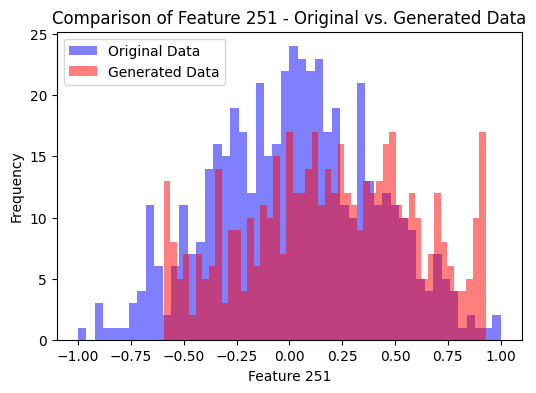

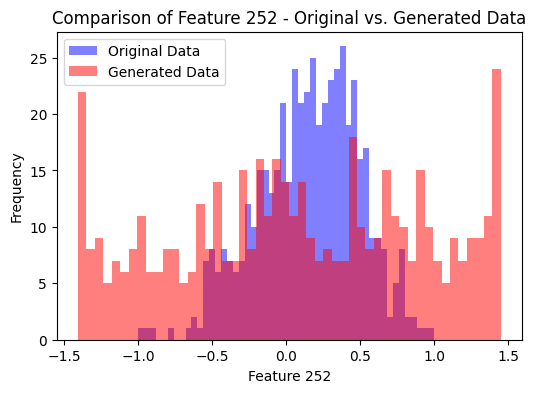

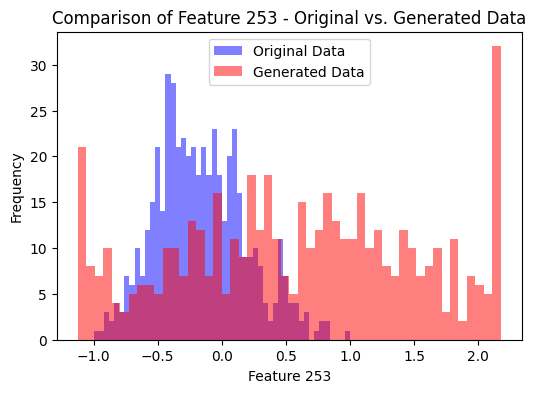

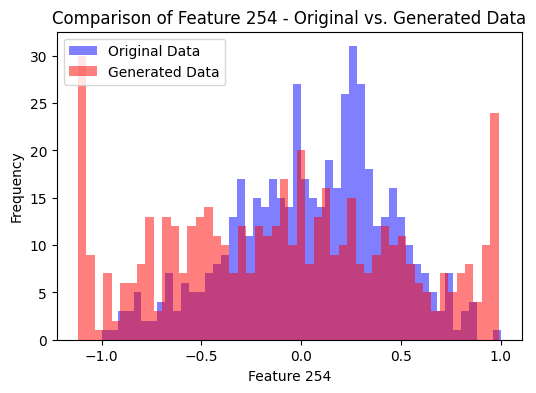

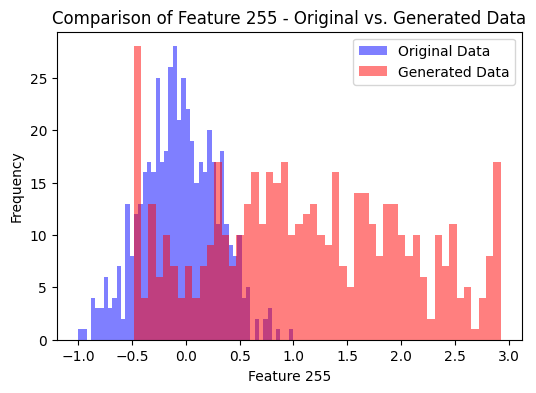

In [ ]:
# Inverse transform the synthetic samples to the original scale
synthetic_samples = scaler.inverse_transform(synthetic_samples.reshape(500, 256))
print(synthetic_samples.shape)
# Create histograms to compare the statistics of the original and generated data
for i in range(256):  # Assuming 256 dimensions
    plt.figure(figsize=(6, 4))
    plt.hist(emb_smiles_data.reshape(500, 256)[:, i], bins=50, alpha=0.5, label='Original Data', color='blue')
    plt.hist(synthetic_samples[:, i], bins=50, alpha=0.5, label='Generated Data', color='red')
    plt.xlabel(f'Feature {i}')
    plt.ylabel('Frequency')
    plt.title(f'Comparison of Feature {i} - Original vs. Generated Data')
    plt.legend()
    plt.show()

In [ ]:

synthetic_samples = scaler.inverse_transform(synthetic_samples)
print(emb_smiles_data.shape)
print(synthetic_samples.shape)

# Inverse transform the synthetic samples to the original scale
synthetic_samples = scaler.inverse_transform(synthetic_samples.reshape(500, 256))
print(synthetic_samples.shape)


In [ ]:
fig, axes = plt.subplots(nrows=32, ncols=8, figsize=(32, 128))

# Flatten the axes array for easy iteration
axes = axes.ravel()

# Create histograms for each dimension and plot them in subplots
for i in range(256):
    ax = axes[i]
    ax.hist(synthetic_samples[:, i], bins=50, alpha=0.5)
    ax.set_title(f'Dim {i}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

# Adjust the layout
#plt.tight_layout()

# Show the plot
plt.show()





In [ ]:
emb_smiles_data = emb_smiles_data.reshape(500,256)




In [ ]:
fig, axes = plt.subplots(nrows=32, ncols=8, figsize=(32, 128))

# Flatten the axes array for easy iteration
axes = axes.ravel()

# Create histograms for each dimension and plot them in subplots
for i in range(256):
    ax = axes[i]
    ax.hist(emb_smiles_data[:, i], bins=50, alpha=0.5)
    ax.set_title(f'Dim {i}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

# Adjust the layout
#plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
print((synthetic_samples.shape))
# print(emb_smiles_data.shape)
emb_smiles_data_reshape = emb_smiles_data.reshape(500,256)
print((emb_smiles_data_reshape.shape))

torch.Size([500, 256])
(500, 256)


In [ ]:
# from scipy.special import kl_div
# # Calculate the KL divergence
# kl_diviv =[]
# for i in range(500):
#     kl_divergence = kl_div(emb_smiles_data_reshape[:,i]/np.sum(emb_smiles_data_reshape[:,i]), synthetic_samples[:,i]/np.sum(synthetic_samples[:,i]))
#     kl_diviv.append(kl_divergence)

df_emb_smiles_data = pd.DataFrame(emb_smiles_data_reshape)
df_synthetic_samples = pd.DataFrame(synthetic_samples)

In [ ]:
df_emb_smiles_data

0         1         2         3         4         5         6    \
0   -0.399918 -0.193074  0.131189  0.419255 -0.524414 -0.329189  0.213420   
1   -0.378191  0.222504  0.453911  0.516864 -0.423875 -0.101968  0.663857   
2    0.217014  0.180103 -0.304342 -0.398830  0.297512 -0.364952  0.273198   
3   -0.305510 -0.569846 -0.091798  0.788637  0.096393  0.378044  0.376912   
4   -0.466898 -0.122988  0.222374  0.338264 -0.139220  0.521941 -0.189182   
..        ...       ...       ...       ...       ...       ...       ...   
495 -0.321540 -0.170083  0.500801 -0.198908 -0.168277  0.424398  0.347879   
496 -0.149743  1.000000  0.495823  0.105661  0.426262  0.339671 -0.420308   
497  0.036742 -0.087145  0.623085  0.394910  0.314288 -0.237944 -0.648049   
498 -0.992348 -0.331644  0.041670  0.109956 -0.211817 -0.352219 -0.052899   
499  0.079979 -0.061490 -0.418683  0.052885  0.421001  0.374221  0.073432   

          7         8         9    ...       246       247       248  \
0   -0.102033 -0.442013  0.238053  ... -0.077239  0.664175  0.004483   
1   -0.337819  0.046448 -0.275801  ...  0.133017  0.064102 -0.321769   
2   -0.228311 -0.166954 -0.127102  ... -0.297459 -0.310358  0.178288   
3    0.247532 -0.383724  0.422890  ... -0.745515  0.070003 -0.116199   
4   -0.079453 -0.514164 -0.396874  ... -0.310248  0.351049  0.130839   
..        ...       ...       ...  ...       ...       ...       ...   
495  0.090506 -0.006710 -0.060489  ...  0.123785  0.055308 -0.004184   
496  0.298271 -0.047847  0.252854  ...  0.141141 -0.062925  0.447734   
497 -0.416464 -0.520740  0.428393  ... -0.140475  0.363425 -0.244620   
498  0.022205  0.458380  0.108221  ... -0.033126  0.029944 -0.010697   
499 -0.208033  0.156263  0.381670  ... -0.519660 -0.206764  0.898970   

          249       250       251       252       253       254       255  
0   -0.221242  0.227696 -0.045665 -0.774422 -0.211893  0.469114 -0.579457  
1   -0.199856 -0.723703  0.079731  0.154297 -0.462041 -0.069142 -0.303107  
2    0.413108  0.550662  0.729071  0.255096  0.501715  0.842239  0.015496  
3    0.318049 -0.227229  0.016903 -0.008708 -0.392721  0.466641 -0.232297  
4    0.135107 -0.715027  0.006227 -0.003577 -0.192094 -0.369376  0.466266  
..        ...       ...       ...       ...       ...       ...       ...  
495  0.158782 -0.532249  0.158261  0.003026 -0.439581 -0.137208  0.552773  
496  0.510140  0.112033  0.590773  0.527617 -0.371712  0.684698 -0.284191  
497  0.238332 -0.128484 -0.655499  0.245783 -0.521025 -0.152223  0.276149  
498  0.223028  0.118233 -0.067543 -0.600410 -0.299909 -0.059688 -0.606996  
499  0.227474  0.121726  0.121267  0.126872  0.268808 -0.039109 -0.502820  

[500 rows x 256 columns]

# Comparing the Syntesized Data with the Originial using elcudian distance in one graph

In [ ]:
from sklearn.metrics import pairwise_distances
# Define the number of intervals (bins)
num_intervals = 100

# Create empty vectors to store the results for each column
column1_vector = np.zeros(num_intervals)
column2_vector = np.zeros(num_intervals)

# Calculate the minimum and maximum values for each column
store_difference = []
for column in range(256):
    min_value_org = df_emb_smiles_data[column].min()
    max_value_org = df_emb_smiles_data[column].max()
    min_value_gen = df_synthetic_samples[column].min()
    max_value_gen = df_synthetic_samples[column].max()

    # Create intervals for each column
    intervals_column1 = np.linspace(min_value_org, max_value_org, num_intervals + 1)
    intervals_column2 = np.linspace(min_value_gen, max_value_gen, num_intervals + 1)

    # Categorize values into intervals and count occurrences for each column
    category_column1 = pd.cut(df_emb_smiles_data[column], bins=intervals_column1)
    category_column2 = pd.cut(df_synthetic_samples[column], bins=intervals_column2)

    counts_column1 = category_column1.value_counts().sort_index().values
    counts_column2 = category_column2.value_counts().sort_index().values

    # Store the counts in the corresponding vectors
    # counts_column1 = counts_column1/float(500.0)
    # counts_column2 = counts_column2/float(500.0)

    #calculate distance and append
    euclidean_distance = np.linalg.norm(counts_column1.reshape(-1,1) -counts_column2.reshape(-1,1))
    store_difference.append(euclidean_distance)

store_difference = np.array(store_difference)

print(pd.DataFrame(store_difference))

             0
0    44.676616
1    50.576674
2    47.444705
3    45.617979
4    42.332021
..         ...
251  36.510273
252  49.608467
253  53.665631
254  46.647615
255  44.676616

[256 rows x 1 columns]


(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  1.,  3.,  1.,
         0.,  3.,  2.,  1.,  2.,  4.,  1.,  1.,  9.,  2.,  2.,  2.,  6.,
         3.,  0.,  5.,  5.,  3.,  3.,  6., 10.,  9.,  5.,  1.,  4.,  1.,
         5.,  2.,  6.,  6., 10.,  9.,  8.,  8.,  5.,  4.,  2.,  7.,  5.,
         5.,  4.,  5.,  2.,  5.,  1.,  4.,  7.,  2.,  3.,  4.,  2.,  3.,
         1.,  3.,  7.,  2.,  1.,  1.,  4.,  2.,  2.,  4.,  0.,  0.,  1.,
         0.,  0.,  1.,  0.,  0.,  2.,  1.,  0.,  1.]),
 array([36.51027253, 36.74700034, 36.98372816, 37.22045597, 37.45718379,
        37.69391161, 37.93063942, 38.16736724, 38.40409505, 38.64082287,
        38.87755068, 39.1142785 , 39.35100632, 39.58773413, 39.82446195,
        40.06118976, 40.29791758, 40.53464539, 40.77137321, 41.00810102,
        41.24482884, 41.48155666, 41.71828447, 41.95501229, 42.1917401 ,
        42.42846792, 42.66519573, 42.90192355, 43.13865137, 43.375379

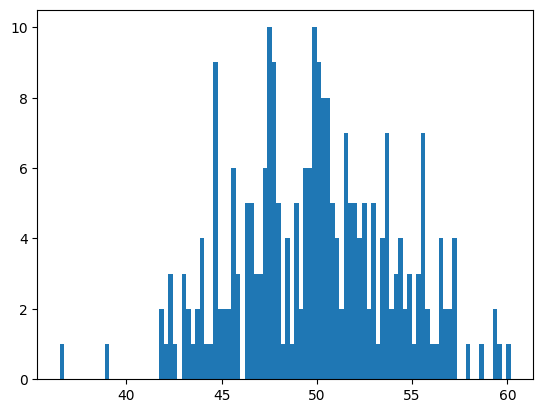

In [ ]:
plt.hist(store_difference,bins=100)

# Condition on logP

In [ ]:
df_500

emb_smiles     logp       qed
0    [-0.04123687, -0.32528168, 0.14484976, 0.52698...  2.17670  0.757009
1    [-0.017471574, 0.26563734, 0.49353746, 0.61067...  2.94340  0.411680
2    [0.6335685, 0.20534664, -0.32572266, -0.174429...  4.03022  0.361633
3    [0.06202714, -0.8610226, -0.09607738, 0.843691...  1.43910  0.873607
4    [-0.1144998, -0.22562544, 0.2433718, 0.4575469... -0.52730  0.658745
..                                                 ...      ...       ...
495  [0.044493817, -0.29259086, 0.5441998, -0.00301...  3.29200  0.288946
496  [0.23240626, 1.3711759, 0.53882176, 0.2581154,...  1.74910  0.627330
497  [0.43638533, -0.17465971, 0.67632294, 0.506114...  1.77710  0.741273
498  [-0.68924093, -0.5223172, 0.048128713, 0.26179...  3.99870  0.729390
499  [0.48367846, -0.13817936, -0.44926342, 0.21286...  4.45280  0.685012

[500 rows x 3 columns]

In [ ]:
#function that provides the emb_smiles when conditioned on logP
def filter(dataframe, lower_bound, upper_bound):
  # Filter the DataFrame based on the range of logp
  filtered_df = df[(df['logp'] >= lower_bound) & (df['logp'] <= upper_bound)]
  result = np.array(filtered_df['emb_smiles'].tolist())
  # print("Res:", result.shape)
  return result


lower_bound = 1.3
upper_bound = 1.8
conditioned_data = filter(df, lower_bound, upper_bound)
conditioned_data_500 = conditioned_data[:500]



In [ ]:
# conditioned_smiles_500= (conditioned_smiles[:500]).astype(float)
print(type(conditioned_data_500))
conditioned_data_500.shape

<class 'numpy.ndarray'>


(500, 256)

In [ ]:
# Create and fit a Min-Max scaler to map conditioned emb_smile data to (-1, 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
cond_smiles_data = (scaler.fit_transform(conditioned_data_500)).reshape(500, 1, 16,16)
print(cond_smiles_data.shape)

(500, 1, 16, 16)


In [ ]:
#Train on the conditioned_smiles

# Define your training parameters, optimizer, and loss function
optimizer = torch.optim.Adam(bfn_model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()  # You may need to choose an appropriate loss function

# Convert NumPy data to PyTorch tensors
emb_smiles_data = torch.tensor(cond_smiles_data)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    optimizer.zero_grad()
    predictions = bfn_model(emb_smiles_data, t=torch.zeros(len(emb_smiles_data)))  # Assuming t=0
    loss = loss_fn(predictions, emb_smiles_data)
    loss.backward()
    optimizer.step()
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')

checkpoint = {
    'epoch': num_epochs,
    'model_state_dict': bfn_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss.item()  # You can also save the current loss if needed
}

# Specify the file path where you want to save the checkpoint
checkpoint_path = '/content/drive/MyDrive'

# Save the checkpoint to the specified file
torch.save(checkpoint, checkpoint_path)

print(f'Model and optimizer states saved to {checkpoint_path}')
# Generate synthetic samples


In [ ]:
 #synthesized smiles based on the conditioned values
checkpoint = torch.load('/content/drive/MyDrive/Colab Notebooks/conditioning_checkpoint.pth')

# Extract the model_state_dict from the checkpoint
model_state_dict = checkpoint['model_state_dict']

bfn_model.load_state_dict(model_state_dict)
# Generate synthetic samples
num_samples = 500
cond_ynthetic_samples = bfn_model.sample(h=16, w=16, batch_size=num_samples,steps=10)

  0%|          | 0/10 [00:00<?, ?it/s]

# Control modifying the inferred logp from generated vectors using the regressor

In [ ]:
#Using the regressor model to get the logP values on the synthesized emb_smiles vectors
synthetic_samples = synthetic_samples.reshape(500, 256)
synth_lgP = regressor.predict(synthetic_samples)
print(synth_lgP.shape)
print(cond_ynthetic_samples.shape)
cond_ynthetic_samples = cond_ynthetic_samples.reshape(500, 256)
cond_synth_lgP = regressor.predict(cond_ynthetic_samples)
print(cond_synth_lgP.shape)

(500,)
torch.Size([500, 256])
(500,)


In [ ]:
# Create a histogram to compare the logP values
import matplotlib.pyplot as plt

#transformed logP values
# Log-transform the logP values
log_transformed_logP = np.log(synth_lgP + 4000)
cond_log_transformed_logP = np.log(cond_synth_lgP + 4000)

plt.hist(log_transformed_logP, bins=10, alpha=0.5, label='Synthesized without Condition', color='blue')
plt.hist(cond_log_transformed_logP, bins=10, alpha=0.5, label='Synthesized with Condition', color='red')

# Add labels and a legend
plt.xlabel('logP Values')
plt.ylabel('Frequency')
plt.legend()

plt.title('Comparison of logP before and after conditioning')

# Show the plot
plt.show()

#The picture below was a screenshot, which I saved. Need to run the whole notebook from top to regenrate the modified one, as runtime on colab got disconnected and it takes time

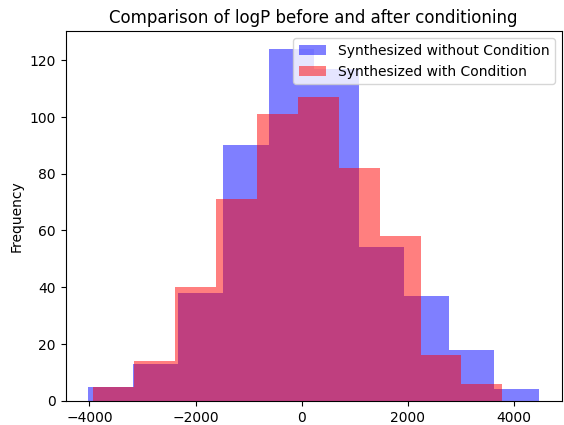

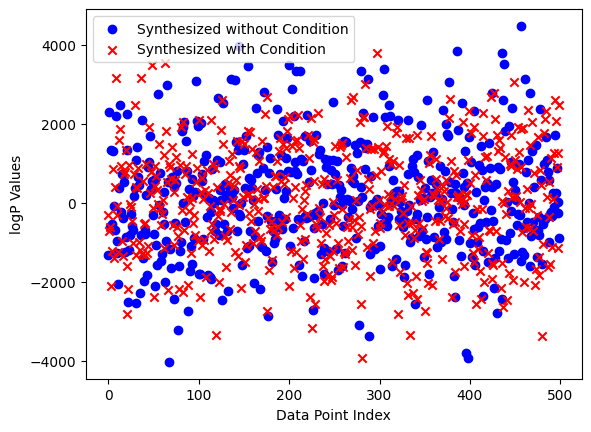

In [ ]:
#Doing a scatter plot

plt.scatter(range(len(synth_lgP)), synth_lgP, label='Synthesized without Condition', color='blue', marker='o')
plt.scatter(range(len(cond_synth_lgP)), cond_synth_lgP, label='Synthesized with Condition', color='red', marker='x')

# Add labels and a legend
plt.xlabel('Data Point Index')
plt.ylabel('logP Values')
plt.legend()

# The logP value helps determine the likelihood of a molecule to have preferable drug like qualities. When conditioning on logP, we essentially train or synthesize emb_smiles, which are more likely to be potential drugs. Without conditioning, the generator synthesizes emb_smiles among which they could or could not have good drug like properties. And such chemical properties can be controlled  based on the conditioning math we did.

# Here, the model was trainned over a very few set of data and the model trainning step was set to 10 (due to compute challenge on colab). And so, increasing the number of trainning data, epoch and number of steps in the model architecture (the sythesize part), we could essentially improve the results, which is also having better control over the generated vectors.
#Secondly, conditioning over Qed score with logP value would allow for even finer control over the generated vectors.